# Jupyter notebook to visualize our results after training PyTorch model

Please run this notebook from the `notebooks` directory.

**Table Of Contents:**
- [Load trained model & apply it to the dataset that includes GRBs we've removed](#load-trained-model-and-apply-it-to-the-dataset-that-includes-grbs-weve-removed)
  - [Imports](#imports)
  - [Load trained model & more](#load-trained-model--more)
  - [Recreate dataset including the GRBs we've removed](#recreate-dataset-including-the-grbs-weve-removed)
  - [Apply our model to that dataset (perform predictions)](#apply-our-model-to-that-dataset-perform-predictions)
- [Exploring our predictions and trained model](#exploring-our-predictions-and-trained-model)
  - [Show residuals, pulls or normalized pulls](#show-residuals-pulls-or-normalized-pulls)
  - [Data points of interest in red](#data-points-of-interest-in-red)
    - [Red points](#red-points)
    - [Comparison with known GRBs](#comparison-with-known-grbs)
  - [Clusters](#clusters)
  - [Intersection of clusters between different `target_name`](#intersection-of-clusters-between-different-target_name)
    - [Data from cluster intersections for $k=5$, discard window of $30$ seconds but different pred_below](#data-from-cluster-intersections-for--discard-window-of-seconds-but-different-pred_below)
  - [Partial derivatives of the predicted target (i.e. output of the model)](#partial-derivatives-of-the-predicted-target-ie-output-of-the-model)
    - [Wrt *normalized* input feature](#wrt-normalized-input-feature)
    - [Wrt *un-normalized* input feature](#wrt-un-normalized-input-feature)
    - [Checking whether using PyTorch autograd instead of the chain rule leads to the same jacobian matrices](#checking-whether-using-pytorch-autograd-instead-of-the-chain-rule-leads-to-the-same-jacobian-matrices)
  - [Heatmap of binned statistic (~ Profile2D histograms )](#heatmap-of-binned-statistic--profile2d-histograms)
- [Exporting into .root format](#exporting-into-root-format)
- [Playground: Manually going through some functions & how they work](#playground-manually-going-through-some-functions--how-they-work)
  - [How to manually inspect a cluster](#how-to-manually-inspect-a-cluster)
  - [Example showing how my code works for the cluster intersections](#example-showing-how-my-code-works-for-the-cluster-intersections)
  - [Testing some stuffs with the autograd](#testing-some-stuffs-with-the-autograd)

Some useful links:
- https://brandonrozek.com/blog/jupyterwithpyenv/

- https://github.com/microsoft/vscode-jupyter/wiki/Setting-Up-Run-by-Line-and-Debugging-for-Notebooks

## Load trained model and apply it to the dataset that includes GRBs we've removed

### Imports

In [1]:
!python --version

Python 3.10.6


In [2]:
import sys
from pathlib import Path

path = lambda x: str(Path(x))

sys.path.append(path("../"))
sys.path.append(path("../src"))

%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import numpy as np
import pandas as pd
import re
import torch
import warnings

from functools import reduce
from hydra import compose, initialize
from ipywidgets import interact, FloatSlider, IntSlider
from mpl_interactions import indexer
from mpl_interactions.widgets import scatter_selector_index
from numpy.typing import NDArray
from pathlib import Path
from src import *
from src.trainer import Trainer
from src.utils import delete
from src.visualizer import plot_val_residual, plot_val_pull, get_all_time_y_y_hat
from src.visualizer import find_moments, get_columns
from torch.utils.data import Subset
from typing import Any

In [4]:
%matplotlib widget

### Load trained model & more

In [5]:
with initialize(version_base=None, config_path=path("../config")):
    cfg = compose(config_name='trainer.yaml')
    # cfg.verbose = True  # XXX: if you want to see much more information
    cfg.wandb.mode = "disabled"
    # Use the GPU when available, otherwise use the CPU
    cfg.common.device = "cuda" if torch.cuda.is_available() else "cpu"  # "cpu"

    root_filename = str(Path("../") / cfg.dataset.filename)
    
    # Let's always recreate our dataset ! (takes some time, about 1-2 min(s) on
    # raidpolar)
    # Otherwise, we need to ensure that the way we create the dataset
    # did not change since last time the .pkl file was created
    cfg.dataset.filename = root_filename
    
    # Otherwise:
    # The following assumes that the user already
    # ran ../src/visualizer.py prior to this (which also recreates the dataset
    # but also saves it in .pkl format).
    # p = Path(root_filename)
    # filename =  f"{str(p.parent)}/{p.stem}_dataset.pkl"
    # if Path(filename).is_file():  # if exists and is a file
    #     cfg.dataset.filename = filename
    # else:
    #     cfg.dataset.filename = root_filename
    #     cfg.dataset.save_format = "pkl"  # to save dataset
    
    trainer = Trainer(cfg)
    print("Loading checkpoint")
    trainer.load_checkpoints(path("../checkpoints/last_general_checkpoint.pth"))

    trainer.model.eval()
    torch.set_grad_enabled(False)
    # it helps with memory-related issues:
    # https://stackoverflow.com/questions/69007342/disable-grad-and-backward-globally
    # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879/15

Creating new columns in data_df


<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide


Filtering some examples/data/rows in data_df
Finished initializing train, val, test Datasets & DataLoaders


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using device: cuda
Initialization Completed
Loading checkpoint


In [6]:
trainer.dataset_full.data_df

unix_time       glat        glon    altitude  temperature  \
0        1.483525e+09  41.273513   64.930544  376.565432    33.500000   
1        1.483525e+09  41.301336   65.091966  376.553905    33.500000   
2        1.483525e+09  41.301336   65.091966  376.553905    33.500000   
3        1.483525e+09  41.328899   65.253475  376.536191    33.500000   
4        1.483525e+09  41.328899   65.253475  376.536191    33.500000   
...               ...        ...         ...         ...          ...   
3950059  1.489745e+09 -42.757777  126.189354  386.590141    34.400002   
3950060  1.489745e+09 -42.758912  126.358379  386.578593    34.400002   
3950061  1.489745e+09 -42.758912  126.358379  386.578593    34.400002   
3950062  1.489745e+09 -42.759779  126.527354  386.562382    34.400002   
3950063  1.489745e+09 -42.759779  126.527354  386.562382    34.400002   

         fe_cosmic    corrected  correrr  config         raz  ...  \
0           1177.0  1111.225454      0.0      42  335.977594  ...   
1           1185.0  1077.260702      0.0      42  336.125659  ...   
2           1185.0  1067.501924      0.0      42  336.125659  ...   
3           2154.0  1108.812904      0.0      42  336.273850  ...   
4           2154.0  1110.524550      0.0      42  336.273850  ...   
...            ...          ...      ...     ...         ...  ...   
3950059    24460.0  1946.386405      0.0      42   91.466481  ...   
3950060    24778.0  2020.254206      0.0      42   91.614903  ...   
3950061    24778.0  1960.692600      0.0      42   91.614903  ...   
3950062    24223.0  2001.103329      0.0      42   91.763169  ...   
3950063    24223.0  2006.959229      0.0      42   91.763169  ...   

         1/rate_err[6]**2  1/rate_err[10]**2  1/rate_err[12]**2  \
0                0.000364           0.000260           0.000270   
1                0.000348           0.000256           0.000257   
2                0.000348           0.000252           0.000253   
3                0.000343           0.000246           0.000247   
4                0.000349           0.000251           0.000252   
...                   ...                ...                ...   
3950059          0.000197           0.000132           0.000132   
3950060          0.000191           0.000130           0.000130   
3950061          0.000197           0.000133           0.000133   
3950062          0.000202           0.000133           0.000133   
3950063          0.000199           0.000133           0.000133   

         rate[0]/rate_err[0]  rate[1]/rate_err[1]  rate[5]/rate_err[5]  \
0                  28.621580            22.109620            54.603536   
1                  27.929632            21.788451            54.791671   
2                  27.636904            21.803819            54.403405   
3                  28.166676            21.966212            55.363248   
4                  28.515913            22.481051            55.182131   
...                      ...                  ...                  ...   
3950059            39.073977            29.911732            73.389050   
3950060            40.109691            31.212337            74.295432   
3950061            39.401131            30.389685            73.269094   
3950062            39.691491            30.651826            72.450085   
3950063            39.764508            31.075422            72.553117   

         rate[6]/rate_err[6]  rate[10]/rate_err[10]  rate[12]/rate_err[12]  \
0                  49.826243              58.944945              57.878622   
1                  50.310019              58.843234              58.802215   
2                  50.046106              58.948036              58.898361   
3                  50.761011              60.010819              59.940325   
4                  50.641369              59.763522              59.708677   
...                      ...                    ...                    ...   
3950059            66.531368              80.931946              8

### Recreate dataset including the GRBs we've removed

In [7]:
# Init trainer with a dataset that doesn't filter out the
# GRBs -> we only use it to obtain the dataset with GRBs
# May take some time as it recreates the dataset
cfg.dataset.filename = root_filename
cfg.dataset.save_format = None
cfg.dataset.filter_conditions = ["rate[0]/rate_err[0] > 20"]

trainer_with_GRBs = Trainer(cfg)
dataset_full_GRBs = trainer_with_GRBs.dataset_full

# Fix the dataset transform to match the transform we used when training the model
dataset_full_GRBs.transform = trainer.dataset_full.transform

# Create a PyTorch Subset with all data
data_df = dataset_full_GRBs.data_df
subset_dataset_full_GRBs = Subset(dataset_full_GRBs,
                                  indices=range(dataset_full_GRBs.n_examples))
# Note: We do it because our functions require PyTorch Subsets as input

Creating new columns in data_df


<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide


Filtering some examples/data/rows in data_df
Finished initializing train, val, test Datasets & DataLoaders
Using device: cuda
Initialization Completed


### Apply our model to that dataset (perform predictions)

<a id='pred'></a>

In [8]:
## Prediction on full dataset with GRBs (e.g rate[0])
# Need to transform before inputting the whole set into the model
X = dataset_full_GRBs.X_cpu
dataset_tensor = trainer.dataset_full.transform(X).to(device=trainer.device)

# Apply the model trained without GRBs to the whole dataset
# including GRBs.
pred = trainer.model(dataset_tensor).detach().to("cpu")

# Remove unused tensors that are on GPU
delete(dataset_tensor)

## Exploring our predictions and trained model

### Show residuals, pulls or normalized pulls

In [9]:
plt.close("all")

# Track the err rate names, they will be used to retrieve the corresponding err rates
rate_err_names = []
# Track figures, they will be later displayed
gcfs = []
target_id_dict = trainer.dataset_full.target_names2id

# Create plots but don't show them now, we will show them later
# via our interactive plots.
with plt.ioff():
    for target_name, i in target_id_dict.items():
        # Depending on the target_name, we plot different things,
        # Either the residual: target-prediction or
        # what we call normalized pull: pull=(target-prediction)/err_rate,
        #                               normalized_pull=pull/std
        # In both cases, we also plot their normalized histograms ('density').
        if target_name not in [f"rate[{i}]" for i in range(13)]:
            fig, fig2 = plot_val_residual(subset_dataset_full_GRBs, pred, target_name=target_name,
                                          save_path=None, save_path_hist=None)
        else:
            # rate[i] != rate[j] in general except if target_names included all the rates.
            j = re.findall("[0-9]+", target_name)[0]
            rate_err_names.append(f"rate_err[{j}]")
            fig, fig2 = plot_val_pull(subset_dataset_full_GRBs, pred, target_name=target_name,
                                      rate_err_name=rate_err_names[-1], save_path=None, save_path_hist=None,
                                      normalized=True,
                                      transform="log")  # or transform="sqrt"
        gcfs += [fig, fig2]
        # Note: Even though we called the function that has as name "plot_val_residual"
        # we apply it to the whole dataset including GRBs. Same thought process
        # for "plot_val_pull".

In [10]:
mpl.rcParams['agg.path.chunksize'] = 10000

Interactive plots using ipywidgets. See these links:
- https://stackoverflow.com/questions/72271574/interactive-plot-of-dataframe-by-index-with-ipywidgets
- https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [11]:
@interact(target_name=list(cfg.dataset.target_names))
def residual_plot(target_name: str) -> mpl.figure.Figure:
    fig = gcfs[2*target_id_dict[target_name]]
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.canvas.header_visible = False
    return fig

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

In [12]:
@interact(target_name=list(cfg.dataset.target_names))
def residual_hist(target_name: str) -> mpl.figure.Figure:
    fig = gcfs[2*target_id_dict[target_name]+1]
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.canvas.header_visible = False
    return fig

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

We used `residual_plot` and `residual_hist` but what we actually plot are either the residuals, the pulls or normalized pulls.

### Data points of interest (in red)

#### Red points

In [13]:
# We do the following instead of picking the target
# from data_df because of what we used in our model.
# The model used PyTorch float tensors (single precision).
# Although the sorting isn't necessary in our case,
# our function also converts PyTorch tensors into NumPy arrays
sorted_time, sorted_y, sorted_y_hat = get_all_time_y_y_hat(subset_dataset_full_GRBs, pred)

# Target - prediction
residuals = sorted_y-sorted_y_hat
# We use the variable "var" to either talk about residuals or pulls
# By default, it's "residual"
var = residuals
var_name = "residual"

# Are our target_names of the form rate[i] ?
target_of_rate_form = np.isin(cfg.dataset.target_names, [f"rate[{i}]" for i in range(13)])

if ~np.any(target_of_rate_form):
    print(f"Thresholding using residuals")
elif np.all(target_of_rate_form):
    # Retrieve the error rates from their names
    rate_errs = get_columns(subset_dataset_full_GRBs, rate_err_names)
    var, var_name = residuals/rate_errs, "pull"
    print("Thresholding using residuals/rate_errs (pull)")
else:
    raise NotImplementedError("Did not implement the case in which the targets are a mix of rate[i] and other")

# Modified gaussian fit
new_mean, new_std = list(zip(*[find_moments(var[:, j]) for j in range(var.shape[1])]))
new_mean, new_std = np.array(new_mean), np.array(new_std)

k = 5
names = ["new_std", "# +ve examples", "# -ve examples"]
counts = pd.DataFrame([new_std, np.sum(var > k*new_std, axis=0), np.sum(var < -k*new_std, axis=0)],
             columns=cfg.dataset.target_names,
             index=names).T.astype({names[1]: 'int',
                                    names[2]: 'int'})
counts

Thresholding using residuals/rate_errs (pull)


new_std  # +ve examples  # -ve examples
rate[0]   1.344533            3952            2576
rate[1]   1.199649            5172            2834
rate[5]   1.322103           18408           15227
rate[6]   1.256458           20015           15480
rate[10]  1.506859           13121           10317
rate[12]  1.501043           13227           10423

Let's show these points of interest:

In [14]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=7, step=0.5, continuous_update=False))
def points_of_interest(target_name: str, k: float) -> None:
    warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
    id = target_id_dict[target_name]
    mask = var[:, id] > k*new_std[id]
    
    fig = plt.figure()
    fig.canvas.header_visible = False
    # Whole dataset in blue
    plt.plot(data_df["unix_time"], data_df[target_name],
         linewidth=0.05, label="whole data")
    # Points of interest in red
    plt.scatter(data_df[mask]["unix_time"],
            data_df[mask][target_name],
            color='r', s=0.1,
            label=fr"data s.t {var_name} > ${k:.1f}\sigma$")
    plt.title(f"{mask.sum()}"+\
                f" data points such that {var_name} "+\
                fr"> ${k:.1f}\sigma$, $\sigma\approx{new_std[id]:.4f}$")
    plt.xlabel("Unix time [s]")
    plt.ylabel("rate[0] [Hz]")
    plt.legend()
    plt.show()
    warnings.filterwarnings("default")

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

Remark: it's maybe a better idea to use `sorted_y`.

#### Comparison with known GRBs

In [15]:
# Import 55 GRBs extracted from:
# https://www.researchgate.net/publication/326811280_Overview_of_the_GRB_observation_by_POLAR
GRBs = pd.read_csv("../data/GRBs.csv")
# Show 5 GRBs
GRBs.head()

Number       GRB_Name         Trigger_time_UTC     unix_time
0       1    GRB_160924A  2016-09-24T06:04:09.040  1.474697e+09
1       2    GRB_160928A  2016-09-28T19:48:05.000  1.475092e+09
2       3  GRB_161009651  2016-10-09T15:38:07.190  1.476027e+09
3       4  GRB_161011217  2016-10-11T05:13:44.420  1.476163e+09
4       5  GRB_161012989  2016-10-12T23:45:11.380  1.476316e+09

Let's only focus on GRBs happening in the same time range as our data

In [16]:
GRB_mask = data_df["unix_time"].min() <= GRBs["unix_time"].values
GRB_mask &= GRBs["unix_time"].values <= data_df["unix_time"].max()
print(f"Out of 55, there are: {GRB_mask.sum()} GRBs within our time range")

Out of 55, there are: 25 GRBs within our time range


Zooming into the GRBs with a window of `w` seconds before and `w` seconds after (`w=100` by default)

In [17]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=7, step=0.5, continuous_update=False),
          w=IntSlider(value=100, min=2, max=1000, step=1, continuous_update=False))
def show_grbs(target_name: str, k: float, w: int) -> None:
     # Show 25 GRBs as well as our predictions and the points of interest
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     id = target_id_dict[target_name]

     # Labels used in the legend
     labels = ["original", "predicted", "GRB trigger time",
               fr"data s.t {var_name} > ${k:.1f}\sigma$"]

     with plt.ioff():
          fig, axs = plt.subplots(5, 5, figsize=(6, 8), sharey=True)
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default
     
     for i, GRB_name, GRB_tunix in zip(range(GRB_mask.sum()),
                         GRBs["GRB_Name"][GRB_mask],
                         GRBs["unix_time"][GRB_mask]):
          # Mask for GRB interval
          m = data_df["unix_time"] >= GRB_tunix-w
          m &= data_df["unix_time"] <= GRB_tunix+w
          m = m.values

          # Mask for GRB interval & red points
          mvar = m & (var[:, id] > k*new_std[id])
          
          if m.sum() > 0:
               t = data_df[m]["unix_time"]
               y = data_df[m][target_name]
               y_hat = pred[:, id][m]

               # Original
               h1, = axs[i//5, i%5].plot(t, y, 'blue', linewidth=0.4)
               # Prediction
               h2, = axs[i//5, i%5].plot(t, y_hat, 'black', linewidth=0.4)
               # GRB trigger time
               h3 = axs[i//5, i%5].vlines(GRB_tunix, 0, y.max(), 'g', linestyle="--")
               axs[i//5, i%5].set_title(GRB_name)

          if mvar.sum() > 0:
               t = data_df[mvar]["unix_time"]
               y = data_df[mvar][target_name]

               # Points of interest in red
               axs[i//5, i%5].scatter(t, y, color='r', alpha=0.25)
          
          axs[i//5, i%5].set_box_aspect(1)
          axs[i//5, i%5].tick_params(axis='both', which='major', labelsize=5)
          axs[i//5, i%5].tick_params(axis='both', which='minor', labelsize=4)
          axs[i//5, i%5].xaxis.offsetText.set_fontsize(5)
     
     h4 = mpatches.Circle([], [], color='r', alpha=0.25)
     plt.legend([h1, h2, h3, h4], labels, bbox_to_anchor=(1, -0.3), loc="upper right")
     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default
     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

**Remarks:** Q: Why zooming or panning in one subplot can also affect the other subplots ? A: It's due to the shared y axis.

Let's also look at the **normalized** residuals or pulls (residuals or pulls divided by the modified standard deviation)

In [18]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=k, min=1, max=7, step=0.5, continuous_update=False),
          w=IntSlider(value=100, min=2, max=1000, step=1, continuous_update=False))
def show_var(target_name: str, k: float, w: int) -> None:
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     id = target_id_dict[target_name]

     # Labels used in the legend
     labels = [f"{var_name}", "GRB trigger time", f"threshold {k}",
               fr"data s.t {var_name} > ${k:.1f}\sigma$"]

     with plt.ioff():
          fig, axs = plt.subplots(5, 5, figsize=(6, 8), sharey=True)
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default
     
     for i, GRB_name, GRB_tunix in zip(range(GRB_mask.sum()),
                         GRBs["GRB_Name"][GRB_mask],
                         GRBs["unix_time"][GRB_mask]):
          # Mask for GRB interval
          m = data_df["unix_time"] >= GRB_tunix-w
          m &= data_df["unix_time"] <= GRB_tunix+w
          m = m.values

          # Mask for GRB interval & red points
          mvar = m & (var[:, id] > k*new_std[id])
          
          if m.sum() > 0:
               t = data_df[m]["unix_time"]
               v_norm = var[:, id][m]/new_std[id]  # Normalize the residuals or pulls

               # Normalized residuals or pulls
               h1, = axs[i//5, i%5].plot(t, v_norm, 'k', linewidth=0.4)
               # GRB trigger time
               h2 = axs[i//5, i%5].vlines(GRB_tunix, v_norm.min(), v_norm.max(), 'g', linestyle="--")
               # 'Threshold line'
               h3, = axs[i//5, i%5].plot(t, k*np.ones_like(t),
                                   linewidth=0.2, color='gray', alpha=0.5,
                                   linestyle="--", zorder=0)
               axs[i//5, i%5].set_title(GRB_name)
               
          if mvar.sum() > 0:
               t = data_df[mvar]["unix_time"]
               v_norm = var[:, id][mvar]/new_std[id]  # Normalize the residuals or pulls

               # Points of interest in red
               axs[i//5, i%5].scatter(t, v_norm, color='r', alpha=0.25)
          
          axs[i//5, i%5].set_box_aspect(1)
          axs[i//5, i%5].tick_params(axis='both', which='major', labelsize=5)
          axs[i//5, i%5].tick_params(axis='both', which='minor', labelsize=4)
          axs[i//5, i%5].xaxis.offsetText.set_fontsize(5)
     
     # Work-around to always show the last label from the legend (data s.t ... > ...). 
     h4 = mpatches.Circle([], [], color='r', alpha=0.25)
     plt.legend([h1, h2, h3, h4], labels, bbox_to_anchor=(1, -0.3), loc="upper right")
     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default
     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

### Clusters

Instead of visualizing each red datapoint of interest independently, we will visualize groups/clusters of them. These clusters have properties attached to them. The starting time, ending time, cluster length and "integral" can be some.

In [19]:
def get_clusters(target_name: str, id: int, k: float, pred_below: bool = True, discard_w: int = 0):
    """
    Return useful information about clusters such as the start and ending times.
    """
    t = data_df["unix_time"].values
    t_flip = np.flip(t)

    ## Red points of interest. Id is used to select a particular output
    if pred_below:
        mask = var[:, id] > k*new_std[id]
    else:
        mask = var[:, id] < -k*new_std[id]

    # Time difference for masked data
    t_mask = data_df[mask]["unix_time"].values
    idx_mask = np.flatnonzero(mask)  # index from original timeline
    delta = np.fix(np.diff(t_mask))
    delta = np.insert(delta, 0, np.inf)
    
    # Time difference for masked flipped data
    t_flip_mask = np.flip(t_mask)
    idx_flip_mask = np.flatnonzero(np.flip(mask))  # index from flipped timeline
    delta_flip = np.fix(np.diff(t_flip_mask))
    delta_flip = np.insert(delta_flip, 0, -np.inf)
    # np.fix rounds to nearest integer to 0.

    ## Starting points of clusters
    # Indices of the start points according to original timeline
    old_idx_points_starts = idx_mask[delta > 1]
    if discard_w:
        # Filter: if discard_w data points before are still within discard_w seconds before, keep the cluster
        t_sec_before_start = t[old_idx_points_starts]-discard_w
        t_data_before_start = np.concatenate([np.array([t[0]-i for i in range(discard_w, 0, -1)]), t])[old_idx_points_starts]
        idx_points_starts = np.intersect1d(old_idx_points_starts[t_data_before_start.astype(int) >= t_sec_before_start.astype(int)],\
                                        old_idx_points_starts)
        cluster_keep_mask = np.isin(old_idx_points_starts, idx_points_starts)
    else:
        idx_points_starts = old_idx_points_starts

    ## Ending points of clusters
    # Indices of the end points according to flipped timeline
    old_idx_points_ends = idx_flip_mask[delta_flip < -1]
    if discard_w:
        # Keep the ends if the starts were kept (again flipped timeline)
        old_idx_points_ends = old_idx_points_ends[np.flip(cluster_keep_mask)]

        # Do something similar to "starts" but on flipped timeline.
        # Filter: if discard_w data points after are still within discard_w seconds after, keep the cluster
        t_sec_after_end = t_flip[old_idx_points_ends]+discard_w
        t_data_after_end = np.concatenate([np.array([t[0]+i for i in range(discard_w, 0, -1)]), t_flip])[old_idx_points_ends]
        idx_points_ends = np.intersect1d(old_idx_points_ends[t_data_after_end.astype(int) <= t_sec_after_end.astype(int)],\
                                        old_idx_points_ends)
        cluster_keep_mask = np.isin(old_idx_points_ends, idx_points_ends)

        # Indices but in ORIGINAL timeline
        old_idx_points_ends = np.flip((t.size - 1) - old_idx_points_ends)
        idx_points_ends = np.flip((t.size - 1) - idx_points_ends)
        
        # Keep the correct starts and ends
        idx_points_starts = idx_points_starts[np.flip(cluster_keep_mask)]
    else:
        # Indices of the end points according to original timeline
        idx_points_ends = np.flip((t.size - 1) - old_idx_points_ends)
    
    # Get the start and end times !
    starts = data_df["unix_time"].iloc[idx_points_starts]
    ends = data_df["unix_time"].iloc[idx_points_ends]
    
    # Recreate mask due to removed clusters
    new_mask = np.zeros_like(mask, dtype=bool)
    for begin, end in zip(idx_points_starts, idx_points_ends):
        new_mask[begin:end+1] = mask[begin:end+1]
    mask = new_mask

    # Recreate times due to removed clusters
    times = data_df[mask]["unix_time"]
    times = times.reset_index(drop=True)

    # Adding a label to each group/cluster
    idx_starts = idx_points_starts
    idx_ends = idx_points_ends
    groups = np.repeat(np.arange(len(idx_starts)), idx_ends - idx_starts + 1)
    
    # XXX: only for the red points of interest !
    data = data_df[mask].copy()
    data["group"] = groups
    data["target_id"] = id

    # Two more properties of clusters
    integrals = data.groupby("group")[target_name].sum().values
    lengths = ends.values-starts.values
    # Drop the column 'group'
    data.drop(columns=["group"], inplace=True)
    
    return mask, data, times, starts, ends, groups, integrals, lengths

In [20]:
def get_cluster_data(t_points, y_points, v_points, starts, ends, cluster_idx):
    """
    Retrieve a particular cluster based on its index
    """
    start, end = starts[cluster_idx], ends[cluster_idx]
    m_points = (t_points>=start) & (t_points<=end)
    return (t_points[m_points],
            y_points[m_points],
            v_points[m_points])

In [21]:
@interact(target_name=list(cfg.dataset.target_names),
          k=FloatSlider(value=5, min=1, max=7, step=0.5, continuous_update=False),
          w=IntSlider(value=100, min=0, max=int(7e6), step=1, continuous_update=False),
          pred_below=IntSlider(value=1, min=0, max=1, step=1, continuous_update=False),
          discard_w=IntSlider(value=0, min=0, max=500, step=1, continuous_update=False))
def plot_clusters(target_name: str, k: float, w: int, pred_below: bool, discard_w: int) -> None:
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     id = target_id_dict[target_name]
     after_plt_show = False  # used to print cluster info after plt.show()
     
     # Information about clusters such as the start and ending times
     out = get_clusters(target_name, id, k,
                        pred_below=bool(pred_below), discard_w=discard_w)
     m_points, data, times, starts, ends, groups, integrals, lengths = out

     # Obtain NumPy arrays and reshape them into column vectors.
     starts = starts.values.reshape(-1, 1)
     ends = ends.values.reshape(-1, 1)
     
     t = data_df["unix_time"].values.reshape(-1, 1)
     y = data_df[target_name].values.reshape(-1, 1)
     y_hat = pred[:, id].numpy().reshape(-1, 1)
     v = var[:, id].reshape(-1, 1)
     t_points = times.values.reshape(-1, 1)
     y_points = data[target_name].values.reshape(-1, 1)
     v_points = var[m_points, id].reshape(-1, 1)
     
     # Retrieve all clusters
     all_clusters_data = [get_cluster_data(t_points, y_points, v_points,
                                           starts, ends, idx) for idx in range(len(starts))]
     
     def get_cluster_times(idx: int) -> NDArray[Any]:
          return all_clusters_data[idx][0]-t[0]

     def get_cluster_targets(_, idx: int) -> NDArray[Any]:
          m = (t>=starts[idx]-w) & (t<=ends[idx]+w)
          min_y, max_y, s_y = y[m].min(), y[m].max(), y[m].std()
          min_v, max_v, s_v = v[m].min(), v[m].max(), v[m].std()

          # Also updates the axis limits
          axs[0, 1].set_xlim([(starts[idx]-w-t[0]).item(), (ends[idx]+w-t[0]).item()])
          axs[0, 1].set_ylim([min_y-s_y, max_y+s_y])
          axs[1, 1].set_xlim([(starts[idx]-w-t[0]).item(), (ends[idx]+w-t[0]).item()])
          axs[1, 1].set_ylim([(min_v-s_v)/new_std[id], (max_v+s_v)/new_std[id]])
          
          if after_plt_show:
               i = idx
               print(f"Cluster n°{i}:\n"+\
                         f"begin={(starts[i]-t[0]).item()}+t[0],\n"+\
                         f"end={(ends[i]-t[0]).item()}+t[0],\nt[0]={t[0].item()}\n"+\
                         fr"length={lengths[i]}, integral$\approx${integrals[i]:.5f}")
          return all_clusters_data[idx][1]

     def get_cluster_normalized_vars(_, idx: int) -> NDArray[Any]:
          return all_clusters_data[idx][2]/new_std[id]

     def get_cluster_length(idx: int) -> NDArray[Any]:
          return lengths[idx].reshape(-1, 1)
          
     def get_cluster_integral(_, idx: int) -> NDArray[Any]:
          return integrals[idx].reshape(-1, 1)

     # Let's plot
     with plt.ioff():
          fig, axs = plt.subplots(2, 2, figsize=(6, 6))
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default

     # https://mpl-interactions.readthedocs.io/en/stable/examples/scatter-selector.html
     fig.canvas.header_visible = False

     # Original
     axs[0, 1].plot(t-t[0], y, linewidth=1, color="b")
     # Prediction
     axs[0, 1].plot(t-t[0], y_hat, linewidth=1, color="k")
     # Normalized Residuals or Pulls (division by std)
     axs[1, 1].plot(t-t[0], v/new_std[id], linewidth=1, color="k")
     # GRB trigger times
     for GRB_tunix in GRBs["unix_time"][GRB_mask]:
          axs[0, 1].vlines(GRB_tunix-t[0], y.min(), y.max(), 'g', linestyle="--")
     # 'Threshold line'
     axs[1, 1].plot(t-t[0], (2*pred_below-1)*k*np.ones_like(t), linewidth=2, color='gray', alpha=0.5,
                    linestyle="--", zorder=0)

     ## Interactive part:
     # Scatter plot of clusters using as coordinates (length, integral)
     index = scatter_selector_index(axs[0, 0], lengths, integrals, color='b', s=5)
     # Points of interest in red
     controls = iplt.scatter(get_cluster_times, get_cluster_targets, idx=index,
                    color='r', alpha=0.25, xlim="auto", ylim="auto", ax=axs[0, 1])
     
     with controls:
          # See: https://mpl-interactions.readthedocs.io/en/stable/examples/plot.html#styling-of-plot
          # Interactive title
          iplt.title(indexer([f"Cluster n°{i}:\n"+\
                              f"begin={(starts[i]-t[0]).item()}+t[0],\n"+\
                              f"end={(ends[i]-t[0]).item()}+t[0],\nt[0]={t[0].item()}\n"+\
                              fr"length={lengths[i]}, integral$\approx${integrals[i]:.5f}" for i in range(len(starts))]),
                         fontsize=5, ax=axs[0, 1])
          # Points of interest in red but in the 'normalized var' plot
          iplt.scatter(get_cluster_times, get_cluster_normalized_vars,
                         color='r', alpha=0.25, xlim="auto", ylim="auto", ax=axs[1, 1])

          # Show in black the selected cluster "point"
          iplt.scatter(get_cluster_length, get_cluster_integral, 
                         color="k", s=5, ax=axs[0, 0])

     # Common settings for all axes
     for ax in [axs[i, j] for i in range(2) for j in range(2)]:
          ax.tick_params(axis='both', which='major', labelsize=5)
          ax.tick_params(axis='both', which='minor', labelsize=4)
          ax.xaxis.offsetText.set_fontsize(5)
          ax.yaxis.offsetText.set_fontsize(5)
          ax.grid("on")

     # Particular settings for different axes
     axs[0, 0].set_xlabel("Length [s]", fontsize=5)
     axs[0, 0].set_ylabel("Integral [Hz]", fontsize=5)

     axs[0, 1].set_xlabel("Unix time - t[0] [s]", fontsize=5)
     axs[0, 1].set_ylabel(target_name, fontsize=5)

     axs[1, 1].set_xlabel("Unix time - t[0] [s]", fontsize=5)
     axs[1, 1].set_ylabel("Normalized " + var_name + ": "+ target_name, fontsize=5)

     # Ignore bottom-left plot
     axs[1, 0].axis('off')

     # 'Fixed' titles
     axs[0, 0].set_title(f"{len(starts)} clusters obtained from data having {var_name}"+\
                         fr" {'> ' if bool(pred_below) else '< -'}${k:.1f}\sigma$"+\
               fr", $\sigma\approx{new_std[id]:.4f}$")
     axs[1, 1].set_title(f"Normalized {var_name} : {target_name}")

     # Displacing the scientific notation text of y axis
     axs[0, 0].yaxis.get_offset_text().set_position((-0.05,0))
     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default

     after_plt_show = True
     
     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

Notes:
- Red points are only shown for the particular cluster
- We defined the cluster length as the ending time minus the starting time.
- Therefore, the single-datapoint cluster length is $0$, not $1$. However, because the sample spacing is $1$ second, one could interprete the cluster length as the ending time minus the starting time plus one.

In [22]:
# Get number of clusters too:
cluster_counts = {f"# {(1-pred_below)*'-'+pred_below*'+'}ve clusters":
                  [get_clusters(target_name, target_id_dict[target_name],
                    k=5,
                    pred_below=pred_below,
                    discard_w=0)[3].size for target_name in cfg.dataset.target_names]
                  for pred_below in [1, 0]}
cluster_counts = pd.DataFrame(cluster_counts, index=cfg.dataset.target_names)
counts = pd.concat([counts, cluster_counts], axis=1)
counts

new_std  # +ve examples  # -ve examples  # +ve clusters  \
rate[0]   1.344533            3952            2576            1507   
rate[1]   1.199649            5172            2834            1969   
rate[5]   1.322103           18408           15227            5500   
rate[6]   1.256458           20015           15480            5893   
rate[10]  1.506859           13121           10317            3967   
rate[12]  1.501043           13227           10423            4004   

          # -ve clusters  
rate[0]             1570  
rate[1]             1682  
rate[5]             6666  
rate[6]             6807  
rate[10]            4700  
rate[12]            4745

In [23]:
# counts.to_pickle(path("../data/num_examples.pkl"))

### Intersection of clusters between different `target_name`

We can be interested in clusters appearing in multiple energy bins (cluster intersections from different energy bins (or `target_name`'s)).

---

In the following cells, there are some `TODO` comments. They point to what can be changed to get different y-axis values in our plots.

How should we deal with the `integrals`? Should it be the sum of `rate[0]`'s from a cluster intersection?

In [24]:
def get_merged_df(k, pred_below, discard_w):
    """
    Merge red points of interests from different energy bins
    """
    # Information about clusters for all target names
    out = [get_clusters(target_name, id, k, pred_below=pred_below, discard_w=discard_w) for id, target_name in enumerate(cfg.dataset.target_names)]
    _, data, _, _, _, _, _, _ = zip(*out)

    # Merge dataframes containing red points of interests from different energy bins
    # Multiple new columns will appear in 'df' due to the different 'target_id''s
    df = reduce(lambda df1,df2: df1.merge(df2, on=list(data_df.keys()), how="outer", sort=True), data)
    # https://stackoverflow.com/questions/42940507/merging-dataframes-keeping-all-items-pandas
    # https://stackoverflow.com/questions/38978214/merge-a-list-of-dataframes-to-create-one-dataframe
    
    # Put the index back
    df = df.set_index(np.flatnonzero(np.isin(data_df["unix_time"], df["unix_time"])))
    nb_inter = df.drop(columns=list(data_df.keys())).count(axis=1)
    
    # Fuse columns:
    df["inter_id"] = df.iloc[:, len(data_df.keys()):].apply(
        lambda x: ','.join(x.dropna().astype(int).astype(str)), axis=1
    )
    # See: https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas
    # Drop columns from the merge:
    df = df[list(data_df.keys()) + ["inter_id"]]
    # Add '# inter' column:
    df["# inter"] = nb_inter
    return df

Getting different properties of cluster intersections doesn't differ much from before:

In [25]:
def get_inter_clusters(df: pd.DataFrame, inter_id_or_cond: str):
    """
    Get different properties of cluster intersections (doesn't differ much from before)
    """
    # XXX: First thing that change compared to before
    # XXX: Only focus on data coming from same type of intersection
    match inter_id_or_cond.split():
        case ["#", "inter", *_]:
            # If inter_id_or_cond is actually not inter_id but is some condition
            # based on # inter:
            match_obj = re.search("# inter", inter_id_or_cond)
            data_inter = df[eval("df['# inter']" + inter_id_or_cond[match_obj.end():])]            
        case _:
            inter_id = inter_id_or_cond
            data_inter = df[df["inter_id"] == inter_id]
    
    # If I want to select all the red points from the first rate
    # data_inter = df[np.array(list(map(lambda x: "0" in x, df["inter_id"])))]
    
    # Compute starts, ends etc.
    t = data_df["unix_time"].values
    t_flip = np.flip(t)

    # XXX: This is the second thing that change compared to before
    mask = np.zeros_like(t, dtype=bool)
    mask[data_inter.index.values] = True
    
    # Time difference for masked data
    t_mask = data_df[mask]["unix_time"].values
    idx_mask = np.flatnonzero(mask)  # index from original timeline
    delta = np.fix(np.diff(t_mask))
    delta = np.insert(delta, 0, np.inf)
    
    # Time difference for masked flipped data
    t_flip_mask = np.flip(t_mask)
    idx_flip_mask = np.flatnonzero(np.flip(mask))  # index from flipped timeline
    delta_flip = np.fix(np.diff(t_flip_mask))
    delta_flip = np.insert(delta_flip, 0, -np.inf)
    # np.fix rounds to nearest integer to 0.

    ## Starting points of clusters
    # Indices of the start points according to original timeline
    old_idx_points_starts = idx_mask[delta > 1]
    idx_points_starts = old_idx_points_starts

    ## Ending points of clusters
    # Indices of the end points according to original timeline
    old_idx_points_ends = np.flip((t.size - 1) - idx_flip_mask[delta_flip < -1])
    idx_points_ends = old_idx_points_ends
    
    # Get the start and end times !
    starts = data_df["unix_time"].iloc[idx_points_starts]
    ends = data_df["unix_time"].iloc[idx_points_ends]
    
    # Recreate mask due to removed clusters
    new_mask = np.zeros_like(mask, dtype=bool)
    for begin, end in zip(idx_points_starts, idx_points_ends):
        new_mask[begin:end+1] = mask[begin:end+1]
    mask = new_mask

    # Recreate times due to removed clusters
    times = data_df[mask]["unix_time"]
    times = times.reset_index(drop=True)

    # Adding a label to each group/cluster
    idx_starts = idx_points_starts
    idx_ends = idx_points_ends
    groups = np.repeat(np.arange(len(idx_starts)), idx_ends - idx_starts + 1)
    
    # XXX: only for the red points of interest !
    data = data_df[mask].copy()
    data["group"] = groups
    
    # Two properties of clusters
    integrals = data.groupby("group")["rate[0]"].sum().values # TODO, change this
    lengths = ends.values-starts.values
    data.drop(columns=["group"], inplace=True)
    return mask, data, times, starts, ends, groups, integrals, lengths

In [26]:
# k, pred_below, discard_w = 5, 1, 30 # 10
k, discard_w = 5, 30
dfs = [get_merged_df(k, pred_below, discard_w) for pred_below in [0, 1]]
df = dfs[1]
# Showing the 5 first rows for pred_below=1
df.head()

/usr/lib/python3/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'target_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


unix_time       glat        glon    altitude  temperature  \
16856  1.483570e+09  42.013855 -117.484493  376.532810    33.900002   
16857  1.483570e+09  42.013855 -117.484493  376.532810    33.900002   
16858  1.483570e+09  42.033823 -117.319147  376.521653    33.900002   
16859  1.483570e+09  42.033823 -117.319147  376.521653    33.900002   
16860  1.483570e+09  42.053478 -117.153731  376.505211    33.900002   

       fe_cosmic    corrected  correrr  config         raz  ...  \
16856    12703.0  5352.537178      0.0      42  338.012145  ...   
16857    12703.0  5477.898393      0.0      42  338.012145  ...   
16858    13033.0  5276.575166      0.0      42  338.162154  ...   
16859    13033.0  5479.149790      0.0      42  338.162154  ...   
16860    12862.0  5322.854914      0.0      42  338.312446  ...   

       1/rate_err[12]**2  rate[0]/rate_err[0]  rate[1]/rate_err[1]  \
16856           0.000041            65.242783            55.817210   
16857           0.000040            66.315694            56.671697   
16858           0.000040            64.506094            54.970257   
16859           0.000040            65.942429            56.427194   
16860           0.000039            65.113563            55.774262   

       rate[5]/rate_err[5]  rate[6]/rate_err[6]  rate[10]/rate_err[10]  \
16856           133.559192           124.912797             137.205403   
16857           134.343495           125.679628             138.163171   
16858           132.406558           123.847528             136.256762   
16859           134.874206           125.985038             138.936836   
16860           135.295795           126.606292             139.229416   

       rate[12]/rate_err[12]  (unix_time-1474004181.5460)//5535.4+10  \
16856             137.205403                                  1738.0   
16857             138.163171                                  1738.0   
16858             136.256762                                  1738.0   
16859             138.936836                                  1738.0   
16860             139.229416                                  1738.0   

       inter_id  # inter  
16856       2,3        2  
16857       2,3        2  
16858       2,3        2  
16859   2,3,4,5        4  
16860   2,3,4,5        4  

[5 rows x 62 columns]

In [27]:
@interact(inter_id_or_cond=list(dfs[1]["inter_id"].unique())+\
          [f"# inter > {i}" for i in range(len(cfg.dataset.target_names))],
          w=IntSlider(value=100, min=0, max=int(7e6), step=1, continuous_update=False))
def plot_inter_clusters(inter_id_or_cond: str, w: int) -> None:
     # XXX: k, pred_below, discard_w are fixed. They were
     # defined earlier, see previous cell.
     # XXX: We plot using rate[0] for the integrals and (normalized) 'vars'
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     id = target_id_dict["rate[0]"]  # TODO: change this
     after_plt_show = False  # used to print cluster info after plt.show()
     
     # Information about cluster intersections such as the start and ending times
     out = get_inter_clusters(df, inter_id_or_cond)
     m_points, data, times, starts, ends, groups, integrals, lengths = out
     
     # Obtain NumPy arrays and reshape them into column vectors.
     starts = starts.values.reshape(-1, 1)
     ends = ends.values.reshape(-1, 1)
     
     t = data_df["unix_time"].values.reshape(-1, 1)
     y = data_df["rate[0]"].values.reshape(-1, 1)  # TODO: change this
     y_hat = pred[:, id].numpy().reshape(-1, 1)  # TODO: change this
     v = var[:, id].reshape(-1, 1)  # TODO: change this
     t_points = times.values.reshape(-1, 1)
     y_points = data["rate[0]"].values.reshape(-1, 1)  # TODO: change this
     v_points = var[m_points, id].reshape(-1, 1)  # TODO: change this
     
     # Retrieve all clusters
     all_clusters_data = [get_cluster_data(t_points, y_points, v_points,
                                           starts, ends, idx) for idx in range(len(starts))]
     def get_cluster_times(idx: int) -> NDArray[Any]:
          return all_clusters_data[idx][0]-t[0]

     def get_cluster_targets(_, idx: int) -> NDArray[Any]:
          m = (t>=starts[idx]-w) & (t<=ends[idx]+w)
          min_y, max_y, s_y = y[m].min(), y[m].max(), y[m].std()
          min_v, max_v, s_v = v[m].min(), v[m].max(), v[m].std()

          # Also updates the axis limits
          axs[0, 1].set_xlim([(starts[idx]-w-t[0]).item(), (ends[idx]+w-t[0]).item()])
          axs[0, 1].set_ylim([min_y-s_y, max_y+s_y])
          axs[1, 1].set_xlim([(starts[idx]-w-t[0]).item(), (ends[idx]+w-t[0]).item()])
          axs[1, 1].set_ylim([(min_v-s_v)/new_std[id], (max_v+s_v)/new_std[id]])
          
          if after_plt_show:
               i = idx
               print(f"Cluster n°{i}:\n"+\
                         f"begin={(starts[i]-t[0]).item()}+t[0],\n"+\
                         f"end={(ends[i]-t[0]).item()}+t[0],\nt[0]={t[0].item()}\n"+\
                         fr"length={lengths[i]}, integral$\approx${integrals[i]:.5f}")
          return all_clusters_data[idx][1]

     def get_cluster_normalized_vars(_, idx) -> NDArray[Any]:
          return all_clusters_data[idx][2]/new_std[id]  # TODO: change this, id

     def get_cluster_length(idx: int) -> NDArray[Any]:
          return lengths[idx].reshape(-1, 1)
          
     def get_cluster_integral(_, idx: int) -> NDArray[Any]:
          return integrals[idx].reshape(-1, 1)

     # Let's plot
     with plt.ioff():
          fig, axs = plt.subplots(2, 2, figsize=(6, 6))
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default

     # https://mpl-interactions.readthedocs.io/en/stable/examples/scatter-selector.html
     fig.canvas.header_visible = False

     # Original
     axs[0, 1].plot(t-t[0], y, linewidth=1, color="b")
     # Prediction
     axs[0, 1].plot(t-t[0], y_hat, linewidth=1, color="k")
     # Normalized Residuals or Pulls (division by std)
     axs[1, 1].plot(t-t[0], v/new_std[id], linewidth=1, color="k")   # TODO: change this (id)
     # GRB trigger times
     for GRB_tunix in GRBs["unix_time"][GRB_mask]:
          axs[0, 1].vlines(GRB_tunix-t[0], y.min(), y.max(), 'g', linestyle="--")
     # 'Threshold line'
     axs[1, 1].plot(t-t[0], (2*1-1)*k*np.ones_like(t), linewidth=2, color='gray', alpha=0.5,
                    linestyle="--", zorder=0)

     ## Interactive part:
     # Scatter plot of clusters using as coordinates (length, integral)
     index = scatter_selector_index(axs[0, 0], lengths, integrals, color='b', s=5)
     # Points of interest in red
     controls = iplt.scatter(get_cluster_times, get_cluster_targets, idx=index,
                    color='r', alpha=0.25, xlim="auto", ylim="auto", ax=axs[0, 1])
     
     with controls:
          # See: https://mpl-interactions.readthedocs.io/en/stable/examples/plot.html#styling-of-plot
          # Interactive title
          iplt.title(indexer([f"Cluster n°{i}:\n"+\
                              f"begin={(starts[i]-t[0]).item()}+t[0],\n"+\
                              f"end={(ends[i]-t[0]).item()}+t[0],\nt[0]={t[0].item()}\n"+\
                              fr"length={lengths[i]}, integral$\approx${integrals[i]:.5f}" for i in range(len(starts))]),
                         fontsize=5, ax=axs[0, 1])
          # Points of interest in red but in the 'normalized var' plot
          iplt.scatter(get_cluster_times, get_cluster_normalized_vars,
                         color='r', alpha=0.25, xlim="auto", ylim="auto", ax=axs[1, 1])

          # Show in black selected cluster "point"
          iplt.scatter(get_cluster_length, get_cluster_integral, 
                         color="k", s=5, ax=axs[0, 0])

     # Common settings for all axes
     for ax in [axs[i, j] for i in range(2) for j in range(2)]:
          ax.tick_params(axis='both', which='major', labelsize=5)
          ax.tick_params(axis='both', which='minor', labelsize=4)
          ax.xaxis.offsetText.set_fontsize(5)
          ax.yaxis.offsetText.set_fontsize(5)
          ax.grid("on")

     # Particular settings for different axes
     axs[0, 0].set_xlabel("Length [s]", fontsize=5)
     axs[0, 0].set_ylabel("Integral [Hz]", fontsize=5)

     axs[0, 1].set_xlabel("Unix time - t[0] [s]", fontsize=5)
     axs[0, 1].set_ylabel("rate[0]", fontsize=5)  # TODO: change this (rate 0)

     axs[1, 1].set_xlabel("Unix time - t[0] [s]", fontsize=5)
     axs[1, 1].set_ylabel("Normalized " + var_name + ": "+ "rate[0]", fontsize=5)  # TODO: change this (rate 0)

     # Ignore bottom-left plot
     axs[1, 0].axis('off')

     # 'Fixed' titles
     axs[0, 0].set_title(f"{len(starts)} clusters obtained from data having {var_name}"+\
                         fr" > ${k:.1f}\sigma$"+\
               fr", $\sigma\approx{new_std[id]:.4f}$")    # TODO: change this (id)
     axs[1, 1].set_title(f"Normalized {var_name} : {'rate[0]'}")    # TODO: change this (rate 0)

     # Displacing the scientific notation text of y axis
     axs[0, 0].yaxis.get_offset_text().set_position((-0.05,0))
     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default

     after_plt_show = True

     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='inter_id_or_cond', options=('2,3', '2,3,4,5', '1,2,3,4,5', '1,2,3'…

There are options from the `inter_id_or_cond` dropdown menu to select all clusters "superposed" except those that don't appear in some specified number of energy bins.

For instance, if we want to show all clusters "superposed" except those that solely come from a single energy bin (a single `rate[i]`), we have to select `# inter > 1`.

#### Data from cluster intersections for $k=5$, discard window of $30$ seconds but different pred_below

In [28]:
dict_counts_inter = {0: {}, 1: {}}
dict_starts_ends = {0: {}, 1: {}}

for pred_below, df in enumerate(dfs):
     inter_id_or_conds = list(df["inter_id"].unique())+\
          [f"# inter > {i}" for i in range(len(cfg.dataset.target_names))]

     for inter_id_or_cond in inter_id_or_conds:
          # XXX: k, pred_below, discard_w are fixed. They were
          # defined earlier
          out = get_inter_clusters(df, inter_id_or_cond)
          m_points, data, times, starts, ends, groups, integrals, lengths = out
          
          dict_counts_inter[pred_below] |= {inter_id_or_cond: starts.size}
          # For the vstack: First col: starts, Second row: ends
          dict_starts_ends[pred_below] |= {inter_id_or_cond.replace(',','_').replace(' ', '_').replace('>','more'):
                                           np.vstack([starts, ends])}

In [29]:
counts_inter = pd.DataFrame(dict_counts_inter).astype(pd.Int64Dtype()).rename(columns={0: 'negative', 1: 'positive'})
counts_inter

negative  positive
2,3,4,5          3703      3474
0,2,3,4,5         263       150
1,2,3,4,5         426       718
2,3              2874      2815
3                1452      1573
0,1,2,3,4,5       833      1028
2,4,5             301       157
2                 926       662
4,5               151       122
2,3,4              14        10
0,2,4,5            17         5
0                  54        40
0,1,2,3            15        31
1                  50        63
0,2                12         5
1,2,3,5             1         5
2,3,5              78        89
5                  13         9
1,2,3              62        90
0,2,3               9         2
1,3                28        47
0,4,5               2        10
0,1,2               5        12
2,5                10         8
1,2                 8         8
3,4,5              20        15
3,5                 3      <NA>
4                   2      <NA>
0,1,4,5             5         7
0,1                26        42
0,2,5               1      <NA>
1,2,4,5             1         6
3,4                 2         1
1,4,5               3         6
0,1,2,4,5           2        17
2,4                 2      <NA>
# inter > 0      6798      5408
# inter > 1      5550      4552
# inter > 2      4029      3332
# inter > 3      3744      3178
# inter > 4      1261      1422
# inter > 5       833      1028
0,1,3,4,5        <NA>         2
1,3,4,5          <NA>         1
1,2,3,4          <NA>         2
0,1,2,3,4        <NA>         1
0,3,4,5          <NA>         1

In [30]:
print(counts_inter.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  negative &  positive \\
\midrule
2,3,4,5     &      3703 &      3474 \\
0,2,3,4,5   &       263 &       150 \\
1,2,3,4,5   &       426 &       718 \\
2,3         &      2874 &      2815 \\
3           &      1452 &      1573 \\
0,1,2,3,4,5 &       833 &      1028 \\
2,4,5       &       301 &       157 \\
2           &       926 &       662 \\
4,5         &       151 &       122 \\
2,3,4       &        14 &        10 \\
0,2,4,5     &        17 &         5 \\
0           &        54 &        40 \\
0,1,2,3     &        15 &        31 \\
1           &        50 &        63 \\
0,2         &        12 &         5 \\
1,2,3,5     &         1 &         5 \\
2,3,5       &        78 &        89 \\
5           &        13 &         9 \\
1,2,3       &        62 &        90 \\
0,2,3       &         9 &         2 \\
1,3         &        28 &        47 \\
0,4,5       &         2 &        10 \\
0,1,2       &         5 &        12 \\
2,5         &        10 &         

In [31]:
dict_starts_ends

{0: {'2_3_4_5': array([[1.48355866e+09, 1.48356006e+09, 1.48356973e+09, ...,
          1.48973813e+09, 1.48974416e+09, 1.48974434e+09],
         [1.48355866e+09, 1.48356006e+09, 1.48356974e+09, ...,
          1.48973813e+09, 1.48974416e+09, 1.48974434e+09]]),
  '0_2_3_4_5': array([[1.48355868e+09, 1.48357550e+09, 1.48357564e+09, 1.48358947e+09,
          1.48359539e+09, 1.48359539e+09, 1.48374660e+09, 1.48374661e+09,
          1.48374661e+09, 1.48374896e+09, 1.48375480e+09, 1.48375481e+09,
          1.48375482e+09, 1.48376637e+09, 1.48376638e+09, 1.48382354e+09,
          1.48383748e+09, 1.48384330e+09, 1.48384910e+09, 1.48392589e+09,
          1.48398895e+09, 1.48399209e+09, 1.48399448e+09, 1.48399472e+09,
          1.48399473e+09, 1.48422253e+09, 1.48424819e+09, 1.48424823e+09,
          1.48426235e+09, 1.48427383e+09, 1.48434549e+09, 1.48434551e+09,
          1.48434551e+09, 1.48434552e+09, 1.48434666e+09, 1.48449910e+09,
          1.48459274e+09, 1.48462544e+09, 1.48462566e+09, 1.4

In [32]:
pd.DataFrame(dict_starts_ends)

0  \
2_3_4_5         [[1483558662.5344625, 1483560059.824113, 14835...   
0_2_3_4_5       [[1483558679.5363069, 1483575495.5065534, 1483...   
1_2_3_4_5       [[1483558759.5449846, 1483575527.508272, 14835...   
2_3             [[1483569782.502532, 1483569799.503707, 148356...   
3               [[1483569783.5025954, 1483575464.5054638, 1483...   
0_1_2_3_4_5     [[1483569785.502657, 1483575337.4996984, 14835...   
2_4_5           [[1483569861.5073915, 1483575400.502856, 14835...   
2               [[1483569887.5096364, 1483575392.5024447, 1483...   
4_5             [[1483575329.4990976, 1483575577.5111876, 1483...   
2_3_4           [[1483589239.6051357, 1484625211.1780608, 1485...   
0_2_4_5         [[1483589341.6079595, 1483766373.0470207, 1484...   
0               [[1483589345.6081614, 1483638447.2796054, 1483...   
0_1_2_3         [[1483595390.6802619, 1483809657.5273607, 1484...   
1               [[1483700716.74588, 1483849047.6861744, 148384...   
0_2             [[1483732581.2793174, 1483980670.0302944, 1486...   
1_2_3_5              [[1483732585.2794054], [1483732585.2794054]]   
2_3_5           [[1483735060.2475307, 1483809272.4508932, 1483...   
5               [[1483735076.2492638, 1484223286.0368855, 1484...   
1_2_3           [[1483760673.6218798, 1483809648.5270836, 1483...   
0_2_3           [[1483809294.4519315, 1484496220.5429826, 1485...   
1_3             [[1483810110.8373907, 1484242466.0980484, 1484...   
0_4_5           [[1483817604.1230168, 1486446023.630264], [148...   
0_1_2           [[1483823710.2872396, 1486021473.8677354, 1486...   
2_5             [[1483983463.6862056, 1485599376.4267025, 1485...   
1_2             [[1483994772.8021104, 1486126524.9299712, 1486...   
3_4_5           [[1484587629.4035156, 1484587632.40365, 148489...   
3_5             [[1484705905.2048728, 1485673886.8193047, 1486...   
4               [[1484935554.7878823, 1486349323.8148491], [14...   
0_1_4_5         [[1485271149.4931614, 1486010415.850649, 14860...   
0_1             [[1485365387.6547258, 1485707496.8805614, 1485...   
0_2_5                [[1485853079.7600179], [1485853079.7600179]]   
1_2_4_5              [[1485894724.8110719], [1485894724.8110719]]   
3_4             [[1485933275.5708523, 1488136503.813054], [148...   
1_4_5           [[1486010419.8509746, 1486010427.8520336, 1486...   
0_1_2_4_5       [[1486016178.5549674, 1488235215.84415], [1486...   
2_4             [[1486109847.4347363, 1486261282.6538222], [14...   
#_inter_more_0  [[1483558662.5344625, 1483558679.5363069, 1483...   
#_inter_more_1  [[1483558662.5344625, 1483558679.5363069, 1483...   
#_inter_more_2  [[1483558662.5344625, 1483558679.5363069, 1483...   
#_inter_more_3  [[1483558662.5344625, 1483558679.5363069, 1483...   
#_inter_more_4  [[1483558679.5363069, 1483558759.5449846, 1483...   
#_inter_more_5  [[1483569785.502657, 1483575337.4996984, 14835...   
0_1_3_4_5                                                     NaN   
1_3_4_5                                                       NaN   
1_2_3_4                                                       NaN   
0_1_2_3_4                                                     NaN   
0_3_4_5                                                       NaN   

                                                                1  
2_3_4_5         [[1483569641.4953258, 1483569650.4962232, 1483...  
0_2_3_4_5       [[1483575291.496834, 1483654565.150102, 148373...  
1_2_3_4_5       [[1483569643.4953427, 1483569647.4961274, 1483...  
2_3             [[1483569638.4952183, 1483569646.496079, 14835...  
3               [[1483569768.5018167, 1483575384.5018597, 1483...  
0_1_2_3_4_5     [[1483575285.4965332, 1483575288.4966824, 1483...  
2_4_5           [[1483569772.5019064, 1483646992.7749734, 1483...  
2               [[1483569653.496376, 1483569673.4970179, 14835...  
4_5             [[1483576005.565316, 1483638313.2678516, 14836...  
2_3_4           [[1483831633.637788, 1483837411.6945765, 14842...  
0_2

In [33]:
dict_starts_ends[pred_below]["#_inter_more_3"].shape

(2, 3178)

/home/zenchiyu/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


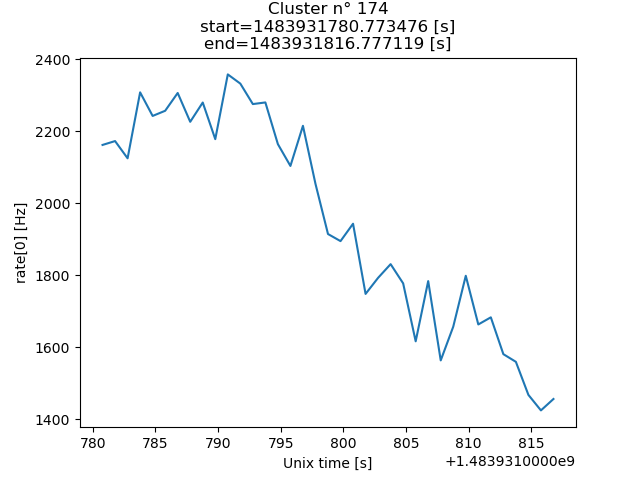

In [34]:
# Showing cluster 174
pred_below = 1
t_s, t_e = dict_starts_ends[pred_below]["#_inter_more_3"][:, 174]
t_tmp = data_df["unix_time"].to_numpy()
mask_cluster_174 = (t_tmp>=t_s) & (t_tmp<=t_e)
del t_tmp

fig = plt.figure()
plt.plot(data_df[mask_cluster_174]["unix_time"],
         data_df[mask_cluster_174]["rate[0]"])
plt.xlabel("Unix time [s]")
plt.ylabel("rate[0] [Hz]")
plt.title(f"Cluster n° 174\nstart={t_s} [s]\nend={t_e} [s]")
plt.show()

### Partial derivatives of the predicted target (i.e. output of the model)


#### Wrt *normalized* input feature

We use the PyTorch autograd automatic differentiation engine to obtain the partial derivatives of the output wrt the input (*normalized* input feature: what is fed as entry to the model):

$$\frac{\partial \hat{y}}{\partial \left(\frac{x(j)-\mu_\text{train}(j)}{\sigma_\text{train}(j)}\right)}$$

where $\left(\frac{x(j)-\mu_\text{train}(j)}{\sigma_\text{train}(j)}\right)$ is the j-th normalized input feature, e.g. normalized crabarf.

Because we can have more than one target variable, we are interested in the Jacobian matrix of each example.

---

Some interesting links:
- https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#differentiation-in-autograd
- *input-gradients*: https://infoscience.epfl.ch/record/289640?ln=fr

For the code below to work, you need to at least run up to ["Apply our model to that dataset (perform predictions)"](#pred) (included).

In [35]:
from torch.utils.data import DataLoader

In [36]:
# Quick look at the model architecture
trainer.model

Sequential(
  (0): Linear(in_features=18, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=6, bias=True)
)

Freeze model parameters as we only want to compute the partial derivatives wrt the input

In [37]:
# Freeze model parameters
for name, param in trainer.model.named_parameters():
    param.requires_grad = False
    print(name, param.requires_grad)

0.weight False
0.bias False
2.weight False
2.bias False
4.weight False
4.bias False
6.weight False
6.bias False


In [38]:
torch.set_grad_enabled(True)  # to track grad_fn again

In [39]:
# Dataloader containing all our examples
dataloader = DataLoader(dataset_full_GRBs,
                        batch_size=cfg.dataset.train.batch_size,
                        shuffle=False,
                        num_workers=4,
                        pin_memory=True)

Compute the partial derivatives for each example (takes about 40-50 seconds on raidpolar)

In [40]:
grads = [[] for i in range(len(cfg.dataset.target_names))]

for (X, y, idxs) in dataloader:
    # Reminder: X was normalized !
    X = X.to(device=trainer.device)
    X.requires_grad_(True)  # tells PyTorch that we want partial derivatives wrt X
    
    y = y.to(device=trainer.device)
    y_hat = trainer.model(X)
    
    for i in range(len(cfg.dataset.target_names)):
        # Fill the .grad attribute of X
        y_hat[:, i].sum().backward(retain_graph=True)  # for rate[i]
        grads[i].append(X.grad.clone())  # need cloning otherwise zero_ will zero out
        # what we appended.
        
        # Zeroing out the .grad before getting the partial derivative wrt
        # another target
        if X.grad is not None:
            X.grad.zero_()

In [41]:
# Jacobian matrix of each example
jacobian_tensor = np.array([torch.cat(grads[i]).detach().cpu().numpy().T for i in range(len(cfg.dataset.target_names))])
jacobian_tensor.shape

(6, 18, 3954837)

The two first tensor dimensions are the number of output and input dimensions. The last dimension represents the number of examples.

In [42]:
target_id_dict = trainer.dataset_full.target_names2id
feature_id_dict = trainer.dataset_full.feature_names2id

In [43]:
@interact(target_name=list(cfg.dataset.target_names),
          feature_name=list(cfg.dataset.feature_names))
def plot_func_and_derivative(target_name: str, feature_name: str) -> None:
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     id_target = target_id_dict[target_name]
     id_feature = feature_id_dict[feature_name]

     # Variables
     x = data_df[feature_name].values
     y = data_df[target_name].values
     y_hat = pred[:, id_target].numpy()
     # Partial derivative of the output specified by target_name
     # wrt normalized input feature based on feature_name
     pdvs = jacobian_tensor[id_target, id_feature]
     
     # Sort by feature
     argsort = np.argsort(x)
     sorted_x = x[argsort]
     sorted_y = y[argsort]
     sorted_y_hat = y_hat[argsort]

     ### Let's plot
     with plt.ioff():
          fig, axs = plt.subplots(1, 2, figsize=(6, 3))
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default
     
     ## These two plots are like projections !
     # Original target wrt feature
     axs[0].plot(sorted_x, sorted_y, linewidth=1, color="b")
     # Prediction wrt feature
     axs[0].plot(sorted_x, sorted_y_hat, linewidth=1, color="k")

     ## Derivatives
     # Histogram
     n, bins, patches = axs[1].hist(pdvs, bins=200, alpha=0.5, log=True)
     area_under_hist = np.sum(n*np.diff(bins))
     
     # Modified Gaussian fit
     f = lambda x, mean, std: 1/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mean)**2/(2*std**2))
     xs = np.linspace(-7*pdvs.std(), 7*pdvs.std(), 255)
     median, (mean, std) = np.median(pdvs), find_moments(pdvs)
     # median, mean, std = np.median(pdvs), np.mean(pdvs), np.std(pdvs)
     
     axs[1].plot(xs, area_under_hist*f(xs, mean, std),
                 zorder=np.inf, color="m", linewidth=1, linestyle="--",
                 label="un-normalized gaussian")
     axs[1].plot([-3*std, -3*std], [1, np.sqrt(10)],
                'r', label=r"$-3\sigma$")
     axs[1].plot([3*std, 3*std], [1, np.sqrt(10)],
                'g', label=r"$+3\sigma$")
     axs[1].plot([median, median], [1, np.sqrt(10)],
                'orange', label="median")
     axs[1].plot([mean, mean], [1, np.sqrt(10)],
                 'k', label="mean")
      
     # Common settings for all axes
     axs[0].tick_params(axis='both', which='major', labelsize=5)
     axs[0].tick_params(axis='both', which='minor', labelsize=4)
     axs[0].xaxis.offsetText.set_fontsize(5)
     axs[0].yaxis.offsetText.set_fontsize(5)
     axs[0].grid("on")

     axs[1].tick_params(axis='both', which='major', labelsize=5)
     axs[1].tick_params(axis='both', which='minor', labelsize=4)
     axs[1].xaxis.offsetText.set_fontsize(5)
     axs[1].yaxis.offsetText.set_fontsize(5)
     axs[1].grid("on")

     # Particular settings for different axes
     axs[0].set_xlabel(feature_name, fontsize=5)
     axs[0].set_ylabel(target_name, fontsize=5)
     
     axs[1].set_xlabel(fr"$\partial${target_name}/$\partial$normalized({feature_name})", fontsize=5)
     axs[1].set_title("Log Histogram\n"+\
                      fr"$\mu\approx{mean:.5f}, \sigma\approx{std:.5f}$"+"\n"+\
                      fr"median$\approx{median:.5f}$")
     axs[1].legend()
     axs[1].set_ylim([1, 3*np.max(n)])

     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default

     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

#### Wrt *un-normalized* input feature

We can compute the partial derivatives wrt un-normalized input features by using what we did previously thanks to the chain rule:

$$\frac{\partial \hat{y}}{\partial x(j)} = \frac{\partial \hat{y}}{\partial \left(\frac{x(j)-\mu_\text{train}(j)}{\sigma_\text{train}(j)}\right)} \frac{\partial \left(\frac{x(j)-\mu_\text{train}(j)}{\sigma_\text{train}(j)}\right)}{\partial x(j)} = \frac{\partial \hat{y}}{\partial \left(\frac{x(j)-\mu_\text{train}(j)}{\sigma_\text{train}(j)}\right)} \frac{1}{\sigma_\text{train}(j)}$$

And again, we'll be interested in the Jacobian matrix of each example.

Let's first retrieve $\mu_\text{train}(j)$'s and $\sigma_\text{train}(j)$'s:

In [44]:
data_train_tensor = trainer.dataset_full.X_cpu[trainer.dataset_train.indices]
mean_train = data_train_tensor.mean(dim=0).numpy()
std_train = data_train_tensor.std(dim=0).numpy()
pd.DataFrame([mean_train, std_train],
             columns=cfg.dataset.feature_names,
             index=["mean_train", "std_train"])

(unix_time-1474004181.5460)//5535.4+10       glat        glon  \
mean_train                             2280.862061   4.056494    4.561670   
std_train                               297.985504  28.820023  109.483337   

              altitude  temperature    fe_cosmic         raz       decz  \
mean_train  379.768768    32.367405  6423.242188  179.930618   9.788474   
std_train     4.812893     2.979678  4529.551270  105.345299  29.233114   

                   rax       decx  is_orbit_up  time_since_saa   crabarf  \
mean_train  187.541031  27.510042     0.497487     4358.934082  1.643559   
std_train   114.054993  37.804764     0.499994     7067.371094  1.547715   

                  sun   sun_spot           B_r       B_theta        B_phi  
mean_train  19.410496  76.886810  -1626.601440 -22410.568359   427.921753  
std_train   15.222263   4.288103  27103.308594   5243.135742  4184.790039

We can now compute $\left[\frac{\partial \hat{y}(k)}{\partial x(j)}\right]_{k=1, ...., \#out,j=1, ...,\#in}$ for each example $i$

In [45]:
# "Un-normalized jacobian_tensor" (with NumPy broadcasting so that shapes match)
jacobian_tensor_denorm = jacobian_tensor/std_train[None, :, None]
jacobian_tensor_denorm.shape

(6, 18, 3954837)

The two first tensor dimensions are the number of output and input dimensions. The last dimension represents the number of examples.

In [46]:
@interact(target_name=list(cfg.dataset.target_names),
          feature_name=list(cfg.dataset.feature_names))
def plot_func_and_derivative(target_name: str, feature_name: str) -> None:
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     id_target = target_id_dict[target_name]
     id_feature = feature_id_dict[feature_name]

     # Variables
     x = data_df[feature_name].values
     y = data_df[target_name].values
     y_hat = pred[:, id_target].numpy()
     pdvs = jacobian_tensor_denorm[id_target, id_feature]
     N = data_df.shape[0]  # number of examples
     
     # Sort by feature
     argsort = np.argsort(x)
     sorted_x = x[argsort]
     sorted_y = y[argsort]
     sorted_y_hat = y_hat[argsort]

     ### Let's plot
     with plt.ioff():
          fig, axs = plt.subplots(1, 2, figsize=(6, 3))
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default
     
     ## These two plots are like projections !
     # Original target wrt feature
     axs[0].plot(sorted_x, sorted_y, linewidth=1, color="b")
     # Prediction wrt feature
     axs[0].plot(sorted_x, sorted_y_hat, linewidth=1, color="k")

     ## Derivatives
     # Histogram
     n, bins, patches = axs[1].hist(pdvs, bins=200, alpha=0.5, log=True)
     area_under_hist = np.sum(n*np.diff(bins))

     # Modified Gaussian fit
     f = lambda x, mean, std: 1/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mean)**2/(2*std**2))
     xs = np.linspace(-7*pdvs.std(), 7*pdvs.std(), 255)
     median, (mean, std) = np.median(pdvs), find_moments(pdvs)
     # median, mean, std = np.median(pdvs), np.mean(pdvs), np.std(pdvs)
     
     axs[1].plot(xs, area_under_hist*f(xs, mean, std),
                 zorder=np.inf, color="m", linewidth=1, linestyle="--",
                 label="un-normalized gaussian")
     axs[1].plot([-3*std, -3*std], [1, np.sqrt(10)],
                'r', label=r"$-3\sigma$")
     axs[1].plot([3*std, 3*std], [1, np.sqrt(10)],
                'g', label=r"$+3\sigma$")
     axs[1].plot([median, median], [1, np.sqrt(10)],
                'orange', label="median")
     axs[1].plot([mean, mean], [1, np.sqrt(10)],
                'k', label="mean")
     axs[1].plot([std/np.sqrt(N), std/np.sqrt(N)], [1, np.sqrt(10)],
                '--r', label=r"$+\sigma/\sqrt{N}$")
     axs[1].plot([-std/np.sqrt(N), -std/np.sqrt(N)], [1, np.sqrt(10)],
                '--r', label=r"$-\sigma/\sqrt{N}$")
      
     # Common settings for all axes
     axs[0].tick_params(axis='both', which='major', labelsize=5)
     axs[0].tick_params(axis='both', which='minor', labelsize=4)
     axs[0].xaxis.offsetText.set_fontsize(5)
     axs[0].yaxis.offsetText.set_fontsize(5)
     axs[0].grid("on")

     axs[1].tick_params(axis='both', which='major', labelsize=5)
     axs[1].tick_params(axis='both', which='minor', labelsize=4)
     axs[1].xaxis.offsetText.set_fontsize(5)
     axs[1].yaxis.offsetText.set_fontsize(5)
     axs[1].grid("on")

     # Particular settings for different axes
     axs[0].set_xlabel(feature_name, fontsize=5)
     axs[0].set_ylabel(target_name, fontsize=5)
     
     axs[1].set_xlabel(fr"$\partial${target_name}/$\partial$({feature_name})", fontsize=5)
     axs[1].set_title("Log Histogram\n"+\
                      fr"$\mu\approx${mean:.5e}, $\sigma\approx${std:.5e}"+"\n"+\
                      r"$\sigma/\sqrt{N}\approx$"+f"{std/np.sqrt(N):.5e}, "+\
                      fr"median$\approx${median:.5e}")
     axs[1].legend()
     axs[1].set_ylim([1, 3*np.max(n)])

     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default

     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='target_name', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]',…

If we don't use the modified gaussian fit:

In [47]:
avg_gradients = jacobian_tensor_denorm.mean(axis=2)
std_gradients = jacobian_tensor_denorm.std(axis=2)

avgs = pd.DataFrame(avg_gradients,
             columns=cfg.dataset.feature_names,
             index=cfg.dataset.target_names)
avgs

(unix_time-1474004181.5460)//5535.4+10       glat      glon  \
rate[0]                                -0.006348  -3.386663  0.330786   
rate[1]                                -0.010823  -2.452014  0.265785   
rate[5]                                -0.053386 -10.668041  1.213200   
rate[6]                                -0.052165  -9.160622  1.098845   
rate[10]                               -0.021446 -11.731500  1.283699   
rate[12]                               -0.021986 -11.747561  1.283299   

           altitude  temperature  fe_cosmic       raz      decz       rax  \
rate[0]    3.571222   -33.282597   0.007810 -0.047000 -0.641412  0.030088   
rate[1]    2.924350   -17.132345   0.000875 -0.036983 -0.460314  0.045000   
rate[5]   15.969980   -57.475300  -0.001699 -0.164603 -2.503865  0.234378   
rate[6]   14.209130   -39.907742  -0.007354 -0.152853 -2.144136  0.227230   
rate[10]  15.576558   -87.980408   0.018327 -0.166832 -2.739608  0.165998   
rate[12]  15.543118   -87.998154   0.018294 -0.166303 -2.735729  0.166432   

              decx  is_orbit_up  time_since_saa   crabarf       sun  sun_spot  \
rate[0]  -0.098069    12.639872        0.001951  0.349014  1.295663 -0.264237   
rate[1]   0.008619     5.853580        0.001382  0.053972  1.044451 -0.104708   
rate[5]  -0.045545    62.795227        0.003153 -1.327235  5.108296 -2.023999   
rate[6]   0.061300    56.010952        0.002400 -1.196382  4.478731 -1.815497   
rate[10] -0.444851    79.014389        0.003677  0.121555  5.035269 -2.237883   
rate[12] -0.441618    78.930992        0.003694  0.085269  5.036671 -2.252445   

               B_r   B_theta     B_phi  
rate[0]  -0.003815  0.053873  0.003346  
rate[1]  -0.002897  0.037117  0.003317  
rate[5]  -0.014491  0.178131  0.019369  
rate[6]  -0.012730  0.151589  0.018343  
rate[10] -0.015298  0.200744  0.017750  
rate[12] -0.015306  0.200876  0.017737

Let's take a look at the "error" on the sample mean using $\frac{\sigma}{\sqrt{N}}$ where $N$ is the number of examples (or partial derivatives in our case).

**Remark:** This formula is related to:
$$
\begin{align}
\sqrt{\text{Var}\left(\frac{1}{N} \sum_{i=1}^N X_i\right)} &\stackrel{\text{indep.}}{=} \sqrt{\frac{1}{N^2}\sum_{i=1}^N \text{Var}\left( X_i\right)}\\
&\stackrel{\text{identical}}{=} \sqrt{\frac{1}{N}\sigma_X^2} = \frac{\sigma_X}{\sqrt{N}}
\end{align}
$$

Where $X_i$ would be replaced by the random variable representing $\frac{\partial \hat{y}}{\partial x(j)}$ for example $i$.

In [48]:
errs = pd.DataFrame(std_gradients/np.sqrt(data_df.shape[0]),
             columns=cfg.dataset.feature_names,
             index=cfg.dataset.target_names)
errs

(unix_time-1474004181.5460)//5535.4+10      glat      glon  \
rate[0]                                 0.000363  0.010689  0.001837   
rate[1]                                 0.000282  0.008524  0.001472   
rate[5]                                 0.001406  0.043592  0.007354   
rate[6]                                 0.001241  0.039022  0.006625   
rate[10]                                0.001445  0.044581  0.007530   
rate[12]                                0.001446  0.044610  0.007534   

          altitude  temperature  fe_cosmic       raz      decz       rax  \
rate[0]   0.035816     0.054984   0.000020  0.001245  0.005142  0.001167   
rate[1]   0.028156     0.042624   0.000017  0.000981  0.004046  0.000908   
rate[5]   0.140837     0.209768   0.000083  0.004862  0.020583  0.004494   
rate[6]   0.124502     0.185488   0.000076  0.004310  0.018273  0.003958   
rate[10]  0.144105     0.215601   0.000084  0.004967  0.021106  0.004615   
rate[12]  0.144223     0.215767   0.000084  0.004971  0.021123  0.004619   

              decx  is_orbit_up  time_since_saa   crabarf       sun  sun_spot  \
rate[0]   0.003075     0.268257        0.000015  0.051959  0.009386  0.042642   
rate[1]   0.002423     0.188477        0.000012  0.040992  0.007393  0.033450   
rate[5]   0.012015     1.049610        0.000059  0.205008  0.036247  0.163267   
rate[6]   0.010646     0.909037        0.000052  0.182578  0.032037  0.143931   
rate[10]  0.012311     1.158128        0.000060  0.210019  0.037042  0.167247   
rate[12]  0.012320     1.157441        0.000060  0.210162  0.037069  0.167373   

               B_r   B_theta     B_phi  
rate[0]   0.000016  0.000091  0.000066  
rate[1]   0.000012  0.000071  0.000052  
rate[5]   0.000064  0.000362  0.000269  
rate[6]   0.000057  0.000322  0.000239  
rate[10]  0.000065  0.000370  0.000273  
rate[12]  0.000065  0.000370  0.000273

In [49]:
pd.DataFrame(avg_gradients > std_gradients/np.sqrt(data_df.shape[0]),
             columns=cfg.dataset.feature_names,
             index=cfg.dataset.target_names)

(unix_time-1474004181.5460)//5535.4+10   glat  glon  altitude  \
rate[0]                                    False  False  True      True   
rate[1]                                    False  False  True      True   
rate[5]                                    False  False  True      True   
rate[6]                                    False  False  True      True   
rate[10]                                   False  False  True      True   
rate[12]                                   False  False  True      True   

          temperature  fe_cosmic    raz   decz   rax   decx  is_orbit_up  \
rate[0]         False       True  False  False  True  False         True   
rate[1]         False       True  False  False  True   True         True   
rate[5]         False      False  False  False  True  False         True   
rate[6]         False      False  False  False  True   True         True   
rate[10]        False       True  False  False  True  False         True   
rate[12]        False       True  False  False  True  False         True   

          time_since_saa  crabarf   sun  sun_spot    B_r  B_theta  B_phi  
rate[0]             True     True  True     False  False     True   True  
rate[1]             True     True  True     False  False     True   True  
rate[5]             True    False  True     False  False     True   True  
rate[6]             True    False  True     False  False     True   True  
rate[10]            True    False  True     False  False     True   True  
rate[12]            True    False  True     False  False     True   True

If we use the modified gaussian fit:

In [50]:
def modified_gaussian_fit_torch(data):
    """
    Find moments, especially std, for gaussian fit
    'ignoring' outliers.
    """
    low = -torch.tensor(torch.inf)
    high = torch.tensor(torch.inf)
    prev_std = torch.tensor(torch.inf)
    std = torch.std(data)
    mean = torch.mean(data)
    
    while ~(torch.isclose(prev_std, std)|torch.isclose(low, high)):
        # Update interval
        low = -3*std + mean
        high = 3*std + mean
        
        prev_std = std
        std = torch.std(data[(data>low) & (data<high)])
        
    if torch.isclose(low, high):
        return mean, 0
    return mean, std

In [51]:
# The following takes about 12.4 seconds to run on raidpolar
# We cannot use torch.vmap as they don't support torch.isclose yet.
avg_modif, std_modif = zip(*[modified_gaussian_fit_torch(torch.from_numpy(jacobian_tensor_denorm[i, j]))\
                             for i in range(len(cfg.dataset.target_names))\
                                for j in range(len(cfg.dataset.feature_names))])
avg_modif = torch.tensor(avg_modif).reshape(len(cfg.dataset.target_names),
                                            len(cfg.dataset.feature_names))
std_modif = torch.tensor(std_modif).reshape(len(cfg.dataset.target_names),
                                            len(cfg.dataset.feature_names))

In [52]:
avgs_modif = pd.DataFrame(avg_modif.numpy(),
                          columns=cfg.dataset.feature_names,
                          index=cfg.dataset.target_names)
avgs_modif

(unix_time-1474004181.5460)//5535.4+10       glat      glon  \
rate[0]                                -0.006348  -3.386663  0.330786   
rate[1]                                -0.010823  -2.452013  0.265785   
rate[5]                                -0.053386 -10.668039  1.213200   
rate[6]                                -0.052165  -9.160622  1.098845   
rate[10]                               -0.021446 -11.731500  1.283699   
rate[12]                               -0.021986 -11.747561  1.283299   

           altitude  temperature  fe_cosmic       raz      decz       rax  \
rate[0]    3.571223   -33.282600   0.007810 -0.047000 -0.641413  0.030088   
rate[1]    2.924349   -17.132353   0.000875 -0.036983 -0.460314  0.045000   
rate[5]   15.969975   -57.475315  -0.001699 -0.164603 -2.503866  0.234378   
rate[6]   14.209127   -39.907715  -0.007354 -0.152853 -2.144137  0.227230   
rate[10]  15.576557   -87.980400   0.018327 -0.166831 -2.739606  0.165998   
rate[12]  15.543121   -87.998154   0.018294 -0.166303 -2.735729  0.166432   

              decx  is_orbit_up  time_since_saa   crabarf       sun  sun_spot  \
rate[0]  -0.098069    12.639869        0.001951  0.349014  1.295663 -0.264237   
rate[1]   0.008619     5.853580        0.001382  0.053972  1.044451 -0.104708   
rate[5]  -0.045545    62.795231        0.003153 -1.327233  5.108298 -2.024002   
rate[6]   0.061300    56.010948        0.002400 -1.196382  4.478731 -1.815495   
rate[10] -0.444852    79.014359        0.003677  0.121556  5.035269 -2.237882   
rate[12] -0.441618    78.930946        0.003694  0.085271  5.036674 -2.252446   

               B_r   B_theta     B_phi  
rate[0]  -0.003815  0.053873  0.003346  
rate[1]  -0.002897  0.037117  0.003317  
rate[5]  -0.014491  0.178131  0.019369  
rate[6]  -0.012730  0.151589  0.018343  
rate[10] -0.015298  0.200744  0.017750  
rate[12] -0.015306  0.200876  0.017737

In [53]:
errs_modif = pd.DataFrame(std_modif.numpy()/np.sqrt(data_df.shape[0]),
                          columns=cfg.dataset.feature_names,
                          index=cfg.dataset.target_names)
errs_modif

(unix_time-1474004181.5460)//5535.4+10      glat      glon  \
rate[0]                                 0.000075  0.001859  0.000348   
rate[1]                                 0.000048  0.001171  0.000209   
rate[5]                                 0.000243  0.005862  0.001037   
rate[6]                                 0.000206  0.004875  0.000847   
rate[10]                                0.000282  0.006962  0.001291   
rate[12]                                0.000282  0.006966  0.001291   

          altitude  temperature  fe_cosmic       raz      decz       rax  \
rate[0]   0.005212     0.011950   0.000005  0.000243  0.000861  0.000213   
rate[1]   0.003411     0.006818   0.000003  0.000150  0.000558  0.000136   
rate[5]   0.017287     0.028890   0.000014  0.000765  0.003023  0.000696   
rate[6]   0.014772     0.023359   0.000012  0.000638  0.002596  0.000586   
rate[10]  0.019615     0.036508   0.000016  0.000914  0.003465  0.000814   
rate[12]  0.019625     0.036574   0.000016  0.000914  0.003466  0.000814   

              decx  is_orbit_up  time_since_saa   crabarf       sun  sun_spot  \
rate[0]   0.000575     0.234473        0.000002  0.008957  0.001062  0.004869   
rate[1]   0.000363     0.154695        0.000001  0.005837  0.000695  0.003162   
rate[5]   0.001871     0.904378        0.000007  0.029830  0.003432  0.015886   
rate[6]   0.001583     0.772325        0.000006  0.025531  0.002923  0.013480   
rate[10]  0.002198     1.028384        0.000008  0.034103  0.003911  0.018295   
rate[12]  0.002199     1.027362        0.000008  0.034117  0.003913  0.018300   

               B_r   B_theta     B_phi  
rate[0]   0.000004  0.000014  0.000005  
rate[1]   0.000002  0.000009  0.000004  
rate[5]   0.000010  0.000041  0.000019  
rate[6]   0.000008  0.000034  0.000017  
rate[10]  0.000013  0.000050  0.000022  
rate[12]  0.000014  0.000050  0.000022

In [54]:
avgs_modif > errs_modif

(unix_time-1474004181.5460)//5535.4+10   glat  glon  altitude  \
rate[0]                                    False  False  True      True   
rate[1]                                    False  False  True      True   
rate[5]                                    False  False  True      True   
rate[6]                                    False  False  True      True   
rate[10]                                   False  False  True      True   
rate[12]                                   False  False  True      True   

          temperature  fe_cosmic    raz   decz   rax   decx  is_orbit_up  \
rate[0]         False       True  False  False  True  False         True   
rate[1]         False       True  False  False  True   True         True   
rate[5]         False      False  False  False  True  False         True   
rate[6]         False      False  False  False  True   True         True   
rate[10]        False       True  False  False  True  False         True   
rate[12]        False       True  False  False  True  False         True   

          time_since_saa  crabarf   sun  sun_spot    B_r  B_theta  B_phi  
rate[0]             True     True  True     False  False     True   True  
rate[1]             True     True  True     False  False     True   True  
rate[5]             True    False  True     False  False     True   True  
rate[6]             True    False  True     False  False     True   True  
rate[10]            True     True  True     False  False     True   True  
rate[12]            True     True  True     False  False     True   True

In [55]:
print((errs_modif).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
{} &  (unix\_time-1474004181.5460)//5535.4+10 &      glat &      glon &  altitude &  temperature &  fe\_cosmic &       raz &      decz &       rax &      decx &  is\_orbit\_up &  time\_since\_saa &   crabarf &       sun &  sun\_spot &       B\_r &   B\_theta &     B\_phi \\
\midrule
rate[0]  &                                0.000075 &  0.001859 &  0.000348 &  0.005212 &     0.011950 &   0.000005 &  0.000243 &  0.000861 &  0.000213 &  0.000575 &     0.234473 &        0.000002 &  0.008957 &  0.001062 &  0.004869 &  0.000004 &  0.000014 &  0.000005 \\
rate[1]  &                                0.000048 &  0.001171 &  0.000209 &  0.003411 &     0.006818 &   0.000003 &  0.000150 &  0.000558 &  0.000136 &  0.000363 &     0.154695 &        0.000001 &  0.005837 &  0.000695 &  0.003162 &  0.000002 &  0.000009 &  0.000004 \\
rate[5]  &                                0.000243 &  0.005862 &  0.001037 &  0.017287 &     0.028890 &   0.000014 &  0.000765 &

Visualize `avgs_modif > errs_modif` and `avgs_modif < -errs_modif`

/tmp/ipykernel_2365977/371435984.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
/home/zenchiyu/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


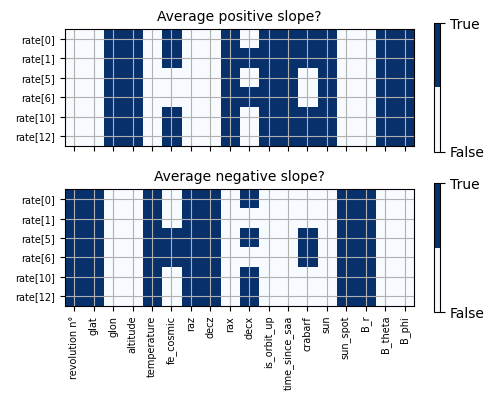

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)

im1 = axs[0].imshow(avgs_modif > errs_modif, cmap=plt.get_cmap("Blues", 2))
im2 = axs[1].imshow(avgs_modif < -errs_modif, cmap=plt.get_cmap("Blues", 2))

axs[0].set_yticks(range(len(cfg.dataset.target_names)),
           cfg.dataset.target_names,
           fontsize=7)
axs[0].grid("on")
axs[0].set_title("Average positive slope?", fontsize=10)
cbar1 = plt.colorbar(im1, ax=axs[0], fraction=0.04, ticks=[0, 1])
cbar1.ax.set_yticklabels(["False", "True"])
axs[1].set_yticks(range(len(cfg.dataset.target_names)),
           cfg.dataset.target_names,
           fontsize=7)
axs[1].set_xticks(range(len(cfg.dataset.feature_names)),
           ["revolution n°"]+cfg.dataset.feature_names[1:],
           rotation='vertical',
           fontsize=7)
axs[1].grid("on")
axs[1].set_title("Average negative slope?", fontsize=10)
cbar2 = plt.colorbar(im2, ax=axs[1], fraction=0.04, ticks=[0, 1])
cbar2.ax.set_yticklabels(["False", "True"])
plt.tight_layout()
plt.show()

What about `avgs_modif > 10*errs_modif` and `avgs_modif < -10*errs_modif`

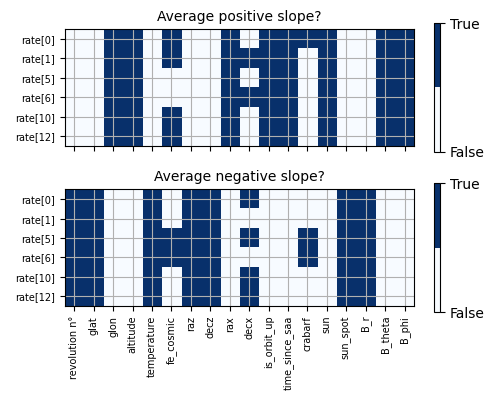

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)

im1 = axs[0].imshow(avgs_modif > 10*errs_modif, cmap=plt.get_cmap("Blues", 2))
im2 = axs[1].imshow(avgs_modif < -10*errs_modif, cmap=plt.get_cmap("Blues", 2))

axs[0].set_yticks(range(len(cfg.dataset.target_names)),
           cfg.dataset.target_names,
           fontsize=7)
axs[0].grid("on")
axs[0].set_title("Average positive slope?", fontsize=10)
cbar1 = plt.colorbar(im1, ax=axs[0], fraction=0.04, ticks=[0, 1])
cbar1.ax.set_yticklabels(["False", "True"])
axs[1].set_yticks(range(len(cfg.dataset.target_names)),
           cfg.dataset.target_names,
           fontsize=7)
axs[1].set_xticks(range(len(cfg.dataset.feature_names)),
           ["revolution n°"]+cfg.dataset.feature_names[1:],
           rotation='vertical',
           fontsize=7)
axs[1].grid("on")
axs[1].set_title("Average negative slope?", fontsize=10)
cbar2 = plt.colorbar(im2, ax=axs[1], fraction=0.04, ticks=[0, 1])
cbar2.ax.set_yticklabels(["False", "True"])
plt.tight_layout()
plt.show()

#### Checking whether using PyTorch autograd instead of the chain rule leads to the same jacobian matrices

In [58]:
# No transform!
dataset_full_GRBs.transform = None
# Dataloader containing all our examples
dataloader_no_transform = DataLoader(dataset_full_GRBs,
                                     batch_size=cfg.dataset.train.batch_size,
                                     shuffle=False,
                                     num_workers=4,
                                     pin_memory=True)

# Compute the partial derivatives for each example (takes about 50-60 seconds on raidpolar)
grads_no_transform = [[] for i in range(len(cfg.dataset.target_names))]

for (X, y, idxs) in dataloader_no_transform:
    # Reminder: X is NOT normalized !
    X = X.to(device=trainer.device)
    X.requires_grad_(True)  # tells PyTorch that we want partial derivatives wrt X
    
    y = y.to(device=trainer.device)
    # Need to normalize X before feeding it to our model !
    y_hat = trainer.model(trainer.dataset_full.transform(X.to(device="cpu")).to(device=trainer.device))
    
    for i in range(len(cfg.dataset.target_names)):
        # Fill the .grad attribute of X
        y_hat[:, i].sum().backward(retain_graph=True)  # for rate[i]
        grads_no_transform[i].append(X.grad.clone())  # need cloning otherwise zero_ will zero out
        # what we appended.
        
        # Zeroing out the .grad before getting the partial derivative wrt
        # another target
        if X.grad is not None:
            X.grad.zero_()

# Use the transform again
dataset_full_GRBs.transform = trainer.dataset_full.transform

In [59]:
# Jacobian matrix of each example
j = np.array([torch.cat(grads_no_transform[i]).detach().cpu().numpy().T for i in range(len(cfg.dataset.target_names))])
print(j.shape)

# Checking whether using PyTorch autograd instead of the
# chain rule leads to the same jacobian matrices
if np.all(np.isclose(j, jacobian_tensor_denorm)):
    print("The jacobian matrices obtained are the same!")
else:
    print("The jacobian matrices obtained are NOT the same!"+\
          "Something is wrong with our chain rule")

(6, 18, 3954837)
The jacobian matrices obtained are the same!


### Heatmap of binned statistic (~ Profile2D histograms )

We used `scipy.stats.binned_statistic_2d` with matplotlib `imshow` to partially reproduce ROOT-CERN "Profile2D histograms" which display the mean value of Z and its error for each cell in X,Y.

In our case, we only display the mean value of Z for each cell X,Y.

Some links:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html#scipy.stats.binned_statistic_2d
- https://root.cern.ch/doc/master/classTProfile2D.html

In [60]:
from scipy import stats

In [61]:
@interact(z=list(cfg.dataset.target_names),  # target_name
          x=list(cfg.dataset.feature_names),  # feature_name_1
          y=list(cfg.dataset.feature_names))  # feature_name_2
def plot_contour(z: str, x: str, y: str) -> None:
     warnings.filterwarnings("ignore")  # XXX: hides some deprecation warnings!
     feature_name_1 = x
     feature_name_2 = y
     target_name = z
     
     id = target_id_dict[target_name]
     id_feature_1 = feature_id_dict[feature_name_1]
     id_feature_2 = feature_id_dict[feature_name_2]

     # Variables
     x1 = data_df[feature_name_1].values
     x2 = data_df[feature_name_2].values
     y = data_df[target_name].values
     y_hat = pred[:, id].numpy()
     cmap = 'gnuplot2'
     
     # Let's plot
     with plt.ioff():
          fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
     fig.canvas.header_visible = False
     mpl.rcParams.update({'font.size': 5})  # 10 is default

     axs[0, 0].plot(x1, x2, '.b', markersize=0.01)

     # 'Quantized heatmap'
     binx, biny = 200, 200  # due to the xlim, ylim -> can be rectangular areas
     prof1 = stats.binned_statistic_2d(x1, x2, y, 'mean', bins=[binx, biny],
                                        expand_binnumbers=True)
     prof2 = stats.binned_statistic_2d(x1, x2, y_hat, 'mean', bins=[binx, biny],
                                        expand_binnumbers=True)
     h1 = axs[0, 1].imshow(prof1.statistic.T, cmap=cmap, origin="lower",
                           interpolation="none",
                           extent=[prof1.x_edge.min(), prof1.x_edge.max(),
                                   prof1.y_edge.min(), prof1.y_edge.max()],
                           aspect="auto")
     h2 = axs[1, 1].imshow(prof2.statistic.T, cmap=cmap, origin="lower",
                           interpolation="none",
                           extent=[prof2.x_edge.min(), prof2.x_edge.max(),
                                   prof2.y_edge.min(), prof2.y_edge.max()],
                           aspect="auto")
     # XXX: https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
     fig.colorbar(h1, ax=axs[0, 1])
     fig.colorbar(h2, ax=axs[1, 1])
          
     # Common settings for all axes
     for ax in [axs[i, j] for i in range(2) for j in range(2)]:
          ax.tick_params(axis='both', which='major', labelsize=5)
          ax.tick_params(axis='both', which='minor', labelsize=4)
          ax.xaxis.offsetText.set_fontsize(5)
          ax.yaxis.offsetText.set_fontsize(5)
          ax.grid("on")
          ax.set_xlabel(feature_name_1, fontsize=5)
          ax.set_ylabel(feature_name_2, fontsize=5)


     # Particular settings for different axes
     axs[0, 1].set_title(target_name)
     axs[1, 1].set_title("Prediction of " + target_name)
     axs[1, 0].axis("off")
     
     plt.tight_layout()
     plt.show()
     mpl.rcParams.update({'font.size': 10})  # 10 is default

     warnings.filterwarnings("default")

interactive(children=(Dropdown(description='z', options=('rate[0]', 'rate[1]', 'rate[5]', 'rate[6]', 'rate[10]…

## Exporting into .root format

We use uproot to export our predictions over the whole dataset with GRBs in `.root` format.

See these links for more information:
- https://uproot.readthedocs.io/en/latest/basic.html#writing-objects-to-a-file
- https://uproot.readthedocs.io/en/latest/basic.html#writing-ttrees-to-a-file

In [62]:
import uproot as ur

In [63]:
out_root_filename = path('../data/pred_nf1rate.root')

In [64]:
with ur.recreate(out_root_filename) as file:
    my_dict = {"unix_time": data_df["unix_time"].values}
    my_dict |= {"pred_rate": pred.numpy()}
    file["pred_nf1rate"] = my_dict
    file["pred_nf1rate"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
unix_time            | double                   | AsDtype('>f8')
pred_rate            | float[6]                 | AsDtype("('>f4', (6,))")


In [65]:
out_root_filename_cluster_inter = path('../data/cluster_inter_nf1rate.root')

In [66]:
pd.DataFrame(dict_counts_inter)

0       1
2,3,4,5      3703.0  3474.0
0,2,3,4,5     263.0   150.0
1,2,3,4,5     426.0   718.0
2,3          2874.0  2815.0
3            1452.0  1573.0
0,1,2,3,4,5   833.0  1028.0
2,4,5         301.0   157.0
2             926.0   662.0
4,5           151.0   122.0
2,3,4          14.0    10.0
0,2,4,5        17.0     5.0
0              54.0    40.0
0,1,2,3        15.0    31.0
1              50.0    63.0
0,2            12.0     5.0
1,2,3,5         1.0     5.0
2,3,5          78.0    89.0
5              13.0     9.0
1,2,3          62.0    90.0
0,2,3           9.0     2.0
1,3            28.0    47.0
0,4,5           2.0    10.0
0,1,2           5.0    12.0
2,5            10.0     8.0
1,2             8.0     8.0
3,4,5          20.0    15.0
3,5             3.0     NaN
4               2.0     NaN
0,1,4,5         5.0     7.0
0,1            26.0    42.0
0,2,5           1.0     NaN
1,2,4,5         1.0     6.0
3,4             2.0     1.0
1,4,5           3.0     6.0
0,1,2,4,5       2.0    17.0
2,4             2.0     NaN
# inter > 0  6798.0  5408.0
# inter > 1  5550.0  4552.0
# inter > 2  4029.0  3332.0
# inter > 3  3744.0  3178.0
# inter > 4  1261.0  1422.0
# inter > 5   833.0  1028.0
0,1,3,4,5       NaN     2.0
1,3,4,5         NaN     1.0
1,2,3,4         NaN     2.0
0,1,2,3,4       NaN     1.0
0,3,4,5         NaN     1.0

In [67]:
with ur.recreate(out_root_filename_cluster_inter) as file:
    file["cluster_inter_nf1rate"] = dict_starts_ends[1]  # positive examples
    file["cluster_inter_nf1rate"].show()

    file["negative_cluster_inter_nf1rate"] = dict_starts_ends[0]  # negative examples
    file["negative_cluster_inter_nf1rate"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
2_3                  | double[2815]             | AsDtype("('>f8', (2815,))")
2_3_4_5              | double[3474]             | AsDtype("('>f8', (3474,))")
1_2_3_4_5            | double[718]              | AsDtype("('>f8', (718,))")
1_2_3                | double[90]               | AsDtype("('>f8', (90,))")
2                    | double[662]              | AsDtype("('>f8', (662,))")
3                    | double[1573]             | AsDtype("('>f8', (1573,))")
2_4_5                | double[157]              | AsDtype("('>f8', (157,))")
2_3_5                | double[89]               | AsDtype("('>f8', (89,))")
0_1_2_3_4_5          | double[1028]             | AsDtype("('>f8', (1028,))")
0_2_3_4_5            | double[150]              | AsDtype("('>f8', (150,))")
4_5                  | double[122]              | AsDtype("('>f8',

## Playground: Manually going through some functions & how they work

Careful with variable names, it can break previously working interactive plots.

### How to manually inspect a cluster

In [68]:
def get_clusters_and_more(target_name: str, k: float, pred_below: bool):
    id = target_id_dict[target_name]

    out = get_clusters(target_name, id, k, pred_below=bool(pred_below))
    m_points, data, times, starts, ends, groups, integrals, lengths = out
    starts = starts.values.reshape(-1, 1)
    ends = ends.values.reshape(-1, 1)

    t = data_df["unix_time"].values.reshape(-1, 1)
    y = data_df[target_name].values.reshape(-1, 1)
    y_hat = pred[:, id].numpy().reshape(-1, 1)
    v = var[:, id].reshape(-1, 1)
    t_points = times.values.reshape(-1, 1)
    y_points = data[target_name].values.reshape(-1, 1)
    v_points = var[m_points, id].reshape(-1, 1)
    return (m_points, data, times, starts, ends, groups, integrals, lengths,
            t, y, y_hat, v, t_points, y_points, v_points)

In [69]:
out = get_clusters_and_more(target_name="rate[0]", k=5, pred_below=1)

In [70]:
(m_points_test, data_test, times_test, starts_test,
 ends_test, groups_test, integrals_test, lengths_test,
 t_test, y_test, y_hat_test, v_test, t_points_test,
 y_points_test, v_points_test) = out

In [71]:
m_points_test.sum()

3952

In [72]:
data_test

unix_time       glat        glon    altitude  temperature  \
16830    1.483570e+09  41.731025 -119.623278  376.726384    33.900002   
16831    1.483570e+09  41.731025 -119.623278  376.726384    33.900002   
19017    1.483575e+09  42.750140 -130.034266  375.686263    34.099998   
19018    1.483575e+09  42.752526 -129.864785  375.671705    34.099998   
19020    1.483575e+09  42.754644 -129.695358  375.661943    34.099998   
...               ...        ...         ...         ...          ...   
3901407  1.489684e+09 -42.610297   30.590473  385.941441    32.400002   
3901408  1.489684e+09 -42.601066   30.758606  385.933013    32.400002   
3901409  1.489684e+09 -42.601066   30.758606  385.933013    32.400002   
3901410  1.489684e+09 -42.591516   30.926685  385.922039    32.400002   
3901411  1.489684e+09 -42.591516   30.926685  385.922039    32.400002   

         fe_cosmic    corrected  correrr  config         raz  ...  \
16830      12918.0  5198.924021      0.0      42  336.060392  ...   
16831      12918.0  5208.265132      0.0      42  336.060392  ...   
19017      13284.0  3125.119631      0.0      42  347.467124  ...   
19018      14002.0  3090.781940      0.0      42  347.617835  ...   
19020      13459.0  3230.554356      0.0      42  347.768541  ...   
...            ...          ...      ...     ...         ...  ...   
3901407    13834.0  2963.622708      0.0      42  101.346094  ...   
3901408    15130.0  2870.270224      0.0      42  101.495488  ...   
3901409    15130.0  2974.917323      0.0      42  101.495488  ...   
3901410    15814.0  2975.573251      0.0      42  101.644437  ...   
3901411    15814.0  2771.838998      0.0      42  101.644437  ...   

         1/rate_err[10]**2  1/rate_err[12]**2  rate[0]/rate_err[0]  \
16830             0.000043           0.000043            63.482672   
16831             0.000044           0.000044            64.399478   
19017             0.000082           0.000082            50.658004   
19018             0.000081           0.000081            50.274422   
19020             0.000076           0.000076            51.406781   
...                    ...                ...                  ...   
3901407           0.000086           0.000086            49.559965   
3901408           0.000090           0.000090            48.902350   
3901409           0.000088           0.000088            49.871552   
3901410           0.000088           0.000088            49.663783   
3901411           0.000092           0.000092            48.144650   

         rate[1]/rate_err[1]  rate[5]/rate_err[5]  rate[6]/rate_err[6]  \
16830              55.632905           126.989008           120.027890   
16831              55.930942           129.397695           121.757208   
19017              41.385459            96.732952            88.783724   
19018              41.772869            97.335870            89.860777   
19020              42.944764           100.160175            92.374202   
...                      ...                  ...                  ...   
3901407            40.895064            94.590573            87.448090   
3901408            40.675275            93.201697            85.945422   
3901409            40.895230            93.356163            85.633293   
3901410            41.128444            93.834698            86.497816   
3901411            39.767866            91.870832            84.806185   

         rate[10]/rate_err[10]  rate[12]/rate_err[12]  \
16830               129.577507             129.577507   
16831               132.287308             132.287308   
19017               102.149203             102.149203   
19018               102.758742             102.758742   
19020               105.274023             105.274023   
...                        ...                    ...   
3901407             100.132645             100.127730   
3901408              98.074789              98.074789   
3901409              98.889585              98.885630   
390141

### Example showing how my code works for the cluster intersections

In [73]:
data_test = [
    pd.DataFrame(np.array(
        [
        [1, 1],
        [2, 1],
        [4, 1],
        [5, 1],
        [6, 1],
        [8, 1],
        [9, 1],
        [10, 1]
        ]
    ), columns=["unix_time", "target_id"]),
    pd.DataFrame(np.array(
        [
        [2, 2],
        [3, 2],
        [6, 2],
        [7, 2],
        [8, 2],
        [9, 2],
        ]
    ), columns=["unix_time", "target_id"])
    ,
    pd.DataFrame(np.array(
        [[i, 3] for i in range(11)]
    ), columns=["unix_time", "target_id"])
]

data_test

[   unix_time  target_id
 0          1          1
 1          2          1
 2          4          1
 3          5          1
 4          6          1
 5          8          1
 6          9          1
 7         10          1,
    unix_time  target_id
 0          2          2
 1          3          2
 2          6          2
 3          7          2
 4          8          2
 5          9          2,
     unix_time  target_id
 0           0          3
 1           1          3
 2           2          3
 3           3          3
 4           4          3
 5           5          3
 6           6          3
 7           7          3
 8           8          3
 9           9          3
 10         10          3]

In [74]:
df_test = reduce(lambda df1,df2: df1.merge(df2, on="unix_time", how="outer", sort=True), data_test)

nb_inter = df_test.drop(columns=["unix_time"]).count(axis=1)

# Fuse columns:
df_test["inter_id"] = df_test.iloc[:, len(data_test[0].keys())-1:].apply(
    lambda x: ','.join(x.dropna().astype(int).astype(str)), axis=1
)
# See: https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas

# Drop columns from the merge:
df_test = df_test[["unix_time", "inter_id"]]

# Add # inter column:
df_test["# inter"] = nb_inter

df_test

unix_time inter_id  # inter
0           0        3        1
1           1      1,3        2
2           2    1,2,3        3
3           3      2,3        2
4           4      1,3        2
5           5      1,3        2
6           6    1,2,3        3
7           7      2,3        2
8           8    1,2,3        3
9           9    1,2,3        3
10         10      1,3        2

Note that there can be duplicate rows if there were duplicate rows in the dataframes used as input to `pd.merge`

### Testing some stuffs with the autograd

In [75]:
a = torch.tensor([3., 5.], requires_grad=True)
b = 2*a
c = 3*a

In [76]:
b.sum().backward()

In [77]:
a.grad

tensor([2., 2.])

In [78]:
a = torch.tensor([3., 3., 2.], requires_grad=True)

In [79]:
a = torch.tensor([3., 3., 2.], requires_grad=True)
c = torch.tensor([2., 3., 3.], requires_grad=True)
b = 2*a + c
print(b)
b.sum().backward()
print(a.grad, c.grad)

tensor([8., 9., 7.], grad_fn=<AddBackward0>)
tensor([2., 2., 2.]) tensor([1., 1., 1.])


In [80]:
a = torch.tensor([3., 3., 2.], requires_grad=True)
c = torch.tensor([2., 3., 3.], requires_grad=True)
d = torch.tensor([2., 3., 3.])
b = d @ a + c
print(b)
b.sum().backward()
print(a.grad, c.grad)

tensor([23., 24., 24.], grad_fn=<AddBackward0>)
tensor([6., 9., 9.]) tensor([1., 1., 1.])


For the same `a`, I can have different partial derivatives which was expected.